<h1>Google Analytics customer revenue prediction (Self case study 1)

Problem understanding- Marketing teams want to make appropriate investments in promotional strategies to attract potential customers.But many businesses have only small percentage of customers who produce most of the revenue.According to 80-20 rule only 20% of customers generate 80% of revenue. so we want to identify those customers and do promotions. And identifying those customers and predict the revenue generated by them in future is the most difficult part. :(

Analyze Google merchandise store or GStore customer dataset to predict revenue per customer. 
Each row in dataset reprents one visit to the store. We have given Id's to visitor(customer), We have to make predictions for each fullVisitorID. The problem is regression problem.

Data sources:
https://www.kaggle.com/c/ga-customer-revenue-prediction

Metric- RMSE( root mean squared error)

<h2><font color='red'>Data description & preprocessing

In [0]:
#importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm
import json
import gc
import os
from pandas.io.json import json_normalize
from sklearn.externals import joblib

import gc
gc.enable()


import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
customer_train=pd.read_csv("/content/drive/My Drive/GA_customer_revenue_prediction/train/train_v2.csv",dtype={'fullVisitorId': 'str'})
print(customer_train.shape)

(1708337, 13)


In [0]:
customer_test=pd.read_csv("drive/My Drive/GA_customer_revenue_prediction/test_v2.csv",dtype={'fullVisitorId': 'str'})
print(customer_test.shape)

(401589, 13)


In [0]:
#so we have 13 features let's explore what the features are:
customer_train.columns.values

array(['channelGrouping', 'customDimensions', 'date', 'device',
       'fullVisitorId', 'geoNetwork', 'hits', 'socialEngagementType',
       'totals', 'trafficSource', 'visitId', 'visitNumber',
       'visitStartTime'], dtype=object)

In [0]:
customer_train.head()

,channelGrouping,customDimensions,date,device,fullVisitorId,geoNetwork,hits,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",3162355547410993243,"{""continent"": ""Europe"", ""subContinent"": ""Weste...","[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508198450,1,1508198450
1,Referral,"[{'index': '4', 'value': 'North America'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",8934116514970143966,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""referralPath"": ""/a/google.com/transportation...",1508176307,6,1508176307
2,Direct,"[{'index': '4', 'value': 'North America'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",7992466427990357681,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""campaign"": ""(not set)"", ""source"": ""(direct)""...",1508201613,1,1508201613
3,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",9075655783635761930,"{""continent"": ""Asia"", ""subContinent"": ""Western...","[{'hitNumber': '1', 'time': '0', 'hour': '9', ...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508169851,1,1508169851
4,Organic Search,"[{'index': '4', 'value': 'Central America'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",6960673291025684308,"{""continent"": ""Americas"", ""subContinent"": ""Cen...","[{'hitNumber': '1', 'time': '0', 'hour': '14',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508190552,1,1508190552


In [0]:
customer_train.drop(['customDimensions','hits'],axis=1,inplace=True)
print(customer_train.shape)
gc.collect()

(1708337, 11)


195

In [0]:
customer_test.drop(['customDimensions','hits'],axis=1,inplace=True)
print(customer_test.shape)
gc.collect()

(401589, 11)


347

In [0]:
#'json.loads' take a string as input and returns a dictionary as output.
#'json.dumps' take a dictionary as input and returns a string as output.
# json.loads works for one record, for n records you have do record by record
def load_json_data(df_column_name):
 unnormalized=[]# it will be list of dictionaries
 list_values=(list(customer_train[df_column_name].values))
 for i in list_values:
     unnormalized.append(json.loads(i))
 return unnormalized    

In [0]:
def load_json_data_test(df_column_name):
 unnormalized=[]# it will be list of dictionaries
 list_values=(list(customer_test[df_column_name].values))
 for i in list_values:
     unnormalized.append(json.loads(i))
 return unnormalized 

In [0]:
import json
from pandas.io.json import json_normalize
def flatten_json_data(unnormalized):
 normalized=json_normalize(unnormalized)
 return normalized

In [0]:
#Parse the JSON columns into several columns and drop the old JSON columns
#https://www.programiz.com/python-programming/json
JSON_COLUMNS = ['device', 'geoNetwork','totals','trafficSource']
for column in JSON_COLUMNS:
  listofdicts=load_json_data(column)
  flattened_json_column=flatten_json_data(listofdicts)
  if column=='device':
    device_df=flattened_json_column
  elif column=='geoNetwork':
    geoNetwork_df=flattened_json_column
  elif column=='totals':
    totals_df=flattened_json_column
  elif column=='trafficSource':
    trafficSource_df=flattened_json_column

In [0]:
print(device_df.shape)
print(geoNetwork_df.shape)
#print(customDim_df.shape)
print(totals_df.shape)
print(trafficSource_df.shape)
#print(hits_df.shape)

(1708337, 16)
(1708337, 11)
(1708337, 10)
(1708337, 14)


In [0]:
device_df.head()

,browser,browserVersion,browserSize,operatingSystem,operatingSystemVersion,isMobile,mobileDeviceBranding,mobileDeviceModel,mobileInputSelector,mobileDeviceInfo,mobileDeviceMarketingName,flashVersion,language,screenColors,screenResolution,deviceCategory
0,Firefox,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop
1,Chrome,not available in demo dataset,not available in demo dataset,Chrome OS,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop
2,Chrome,not available in demo dataset,not available in demo dataset,Android,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,mobile
3,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop
4,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop


In [0]:
geoNetwork_df.head()

,continent,subContinent,country,region,metro,city,cityId,networkDomain,latitude,longitude,networkLocation
0,Europe,Western Europe,Germany,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not available in demo dataset
1,Americas,Northern America,United States,California,San Francisco-Oakland-San Jose CA,Cupertino,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not available in demo dataset
2,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,windjammercable.net,not available in demo dataset,not available in demo dataset,not available in demo dataset
3,Asia,Western Asia,Turkey,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset
4,Americas,Central America,Mexico,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,prod-infinitum.com.mx,not available in demo dataset,not available in demo dataset,not available in demo dataset


In [0]:
totals_df.head()

,visits,hits,pageviews,bounces,newVisits,sessionQualityDim,timeOnSite,transactions,transactionRevenue,totalTransactionRevenue
0,1,1,1,1,1,1,NaN,NaN,NaN,NaN
1,1,2,2,NaN,NaN,2,28,NaN,NaN,NaN
2,1,2,2,NaN,1,1,38,NaN,NaN,NaN
3,1,2,2,NaN,1,1,1,NaN,NaN,NaN
4,1,2,2,NaN,1,1,52,NaN,NaN,NaN


In [0]:
trafficSource_df.head()

,campaign,source,medium,keyword,adwordsClickInfo.criteriaParameters,referralPath,isTrueDirect,adContent,adwordsClickInfo.page,adwordsClickInfo.slot,adwordsClickInfo.gclId,adwordsClickInfo.adNetworkType,adwordsClickInfo.isVideoAd,campaignCode
0,(not set),google,organic,water bottle,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,(not set),sites.google.com,referral,NaN,not available in demo dataset,/a/google.com/transportation/mtv-services/bike...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,(not set),(direct),(none),NaN,not available in demo dataset,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
# dropping old json columns and merging new ones with customer's dataframe
customer_train.drop(JSON_COLUMNS,axis=1,inplace=True)
print(customer_train.shape)
train_wo_json=pd.concat([customer_train,device_df,geoNetwork_df,totals_df,trafficSource_df],axis=1)
print(train_wo_json.shape)
train_wo_json.to_csv("drive/My Drive/GA_customer_revenue_prediction/data_wo_json_train.csv")

(1708337, 7)
(1708337, 58)


In [0]:
data=list(customer_train['customDimensions'])
cd_list=[]
for i in range(0,len(data)):
  str_to_list=eval(data[i])
  if len(str_to_list)==0:
    dictionary={}
  else:    
    dictionary=str_to_list[0]
  cd_list.append(json.dumps(dictionary))

In [0]:
hits_list=[]
data=list(customer_train['hits'])
for i in range(0,len(data)):
  str_to_list=eval(data[i])
  if len(str_to_list)==0:
    dictionary={}
  else:    
    dictionary=str_to_list[0]
  hits_list.append(json.dumps(dictionary))

In [0]:
# Same parsing for test data
# convert customDimensions and hits to json columns because data in these columns in present as [{'','',''}] which is not json but str
JSON_COLUMNS = ['device', 'geoNetwork','totals','trafficSource']
for column in JSON_COLUMNS:
  listofdicts=load_json_data_test(column)
  flattened_json_column=flatten_json_data(listofdicts)
  if column=='device':
    device_df=flattened_json_column
  elif column=='geoNetwork':
    geoNetwork_df=flattened_json_column
  elif column=='totals':
    totals_df=flattened_json_column
  elif column=='trafficSource':
    trafficSource_df=flattened_json_column

customer_test.drop(JSON_COLUMNS,axis=1,inplace=True)
print(customer_test.shape)
final_test=pd.concat([customer_test,device_df,geoNetwork_df,totals_df,trafficSource_df],axis=1)  

(401589, 7)


In [0]:
print(device_df.shape)
print(geoNetwork_df.shape)
print(totals_df.shape)
print(trafficSource_df.shape)

(401589, 16)
(401589, 11)
(401589, 10)
(401589, 13)


In [0]:
#Filter only those records which have TransactionRevenue value is not NaN.
is_notnull=final_train['transactionRevenue'].notna()

In [0]:
is_notnull

0          False
1          False
2          False
3          False
4          False
           ...  
1708332    False
1708333    False
1708334    False
1708335    False
1708336    False
Name: transactionRevenue, Length: 1708337, dtype: bool

In [0]:
final_train_data_wo_missing_target=final_train[is_notnull]
print(final_train_data_wo_missing_target.shape)
print(final_train_data_wo_missing_target.head())

In [0]:
final_train.nunique()

channelGrouping                              8
date                                       638
fullVisitorId                          1323730
socialEngagementType                         1
visitId                                1665802
visitNumber                                457
visitStartTime                         1667423
browser                                    129
browserVersion                               1
browserSize                                  1
operatingSystem                             24
operatingSystemVersion                       1
isMobile                                     2
mobileDeviceBranding                         1
mobileDeviceModel                            1
mobileInputSelector                          1
mobileDeviceInfo                             1
mobileDeviceMarketingName                    1
flashVersion                                 1
language                                     1
screenColors                                 1
screenResolut

In [0]:
final_test.nunique()# to find out those features which are having cardinality=1

channelGrouping                             8
date                                      168
fullVisitorId                          296530
socialEngagementType                        1
visitId                                393181
visitNumber                               386
visitStartTime                         393643
browser                                    62
browserVersion                              1
browserSize                                 1
operatingSystem                            22
operatingSystemVersion                      1
isMobile                                    2
mobileDeviceBranding                        1
mobileDeviceModel                           1
mobileInputSelector                         1
mobileDeviceInfo                            1
mobileDeviceMarketingName                   1
flashVersion                                1
language                                    1
screenColors                                1
screenResolution                  

In [0]:
# Drop the newly parsed JSON columns that have only 1 unique value because those will not contribute in prediction(cardinality=1)
# check value_counts for each column one by one
cardinality_one=['socialEngagementType','browserVersion','browserSize','operatingSystemVersion','mobileDeviceBranding','mobileDeviceModel','mobileInputSelector','mobileDeviceInfo','mobileDeviceMarketingName','flashVersion','language','screenColors','screenResolution','cityId','latitude','longitude','networkLocation','visits','bounces','newVisits','adwordsClickInfo.criteriaParameters','isTrueDirect','adwordsClickInfo.isVideoAd','campaignCode']
#final_train_data.adwordsClickInfo.page.value_counts()
final_train.drop(cardinality_one,axis=1,inplace=True)

In [0]:
final_train.shape

(1708337, 34)



we are left with 34 independent features 

In [0]:
#same for test but remove campaignCode from the list because this column is not present in test
cardinality_one=['socialEngagementType','browserVersion','browserSize','operatingSystemVersion','mobileDeviceBranding','mobileDeviceModel','mobileInputSelector','mobileDeviceInfo','mobileDeviceMarketingName','flashVersion','language','screenColors','screenResolution','cityId','latitude','longitude','networkLocation','visits','newVisits','bounces','adwordsClickInfo.criteriaParameters','isTrueDirect','adwordsClickInfo.isVideoAd']
final_test.drop(cardinality_one,axis=1,inplace=True)
print(final_test.shape)

(401589, 34)


<h2><font color='green'> Missing values

In [0]:
# Missing data
'''After parsing the JSON data we can observe many missing values in the data set. Let’s find out how many missing values each feature has.
 We need to take into account that such values as “not available in demo dataset”, “(not set)”, “unknown.unknown”, “(not provided)” can be treated as NA.'''
final_train.replace("not available in demo dataset",np.nan,inplace=True)
final_train.replace("(not set)",np.nan,inplace=True)
final_train.replace("(not provided)",np.nan,inplace=True)
final_train.replace("unknown.unknown",np.nan,inplace=True)
# if we hadn't done this replacement, then the below graph would have shown different results which would be wrong

,Total,Percent
totalTransactionRevenue,1689823,0.989163
transactionRevenue,1689823,0.989163
transactions,1689778,0.989136
adContent,1643600,0.962105
adwordsClickInfo.adNetworkType,1633063,0.955937
adwordsClickInfo.slot,1633063,0.955937
adwordsClickInfo.page,1633063,0.955937
adwordsClickInfo.gclId,1632914,0.955850
keyword,1621713,0.949293
campaign,1604526,0.939233


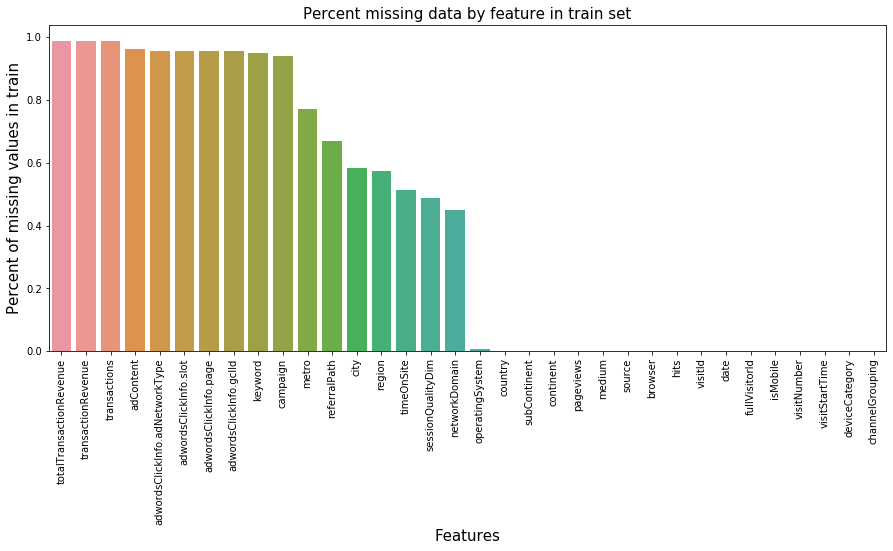

In [0]:
#https://medium.com/@george.drakos62/handling-missing-values-in-machine-learning-part-1-dda69d4f88ca
total = final_train.isnull().sum().sort_values(ascending=False)
percent = (final_train.isnull().sum()/final_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
f, ax = plt.subplots(figsize=(15, 6))
plt.xticks(rotation='90')
sns.barplot(x=missing_data.index, y=missing_data['Percent'])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values in train', fontsize=15)
plt.title('Percent missing data by feature in train set', fontsize=15)
missing_data.head(20)

**In the above bar graph we can see how much data is missing in train set features. almost 98 % data is missing in transaction, transaction revenue & total transaction revenue.  ** 

In [0]:
final_test.replace("not available in demo dataset",np.nan,inplace=True)
final_test.replace("(not set)",np.nan,inplace=True)
final_test.replace("(not provided)",np.nan,inplace=True)
final_test.replace("unknown.unknown",np.nan,inplace=True)

,Total,Percent
totalTransactionRevenue,396995,0.988560
transactionRevenue,396995,0.988560
transactions,395284,0.984300
adwordsClickInfo.adNetworkType,390984,0.973592
adwordsClickInfo.slot,390984,0.973592
adwordsClickInfo.page,390984,0.973592
adwordsClickInfo.gclId,390977,0.973575
adContent,390841,0.973236
keyword,389530,0.969972
campaign,378933,0.943584


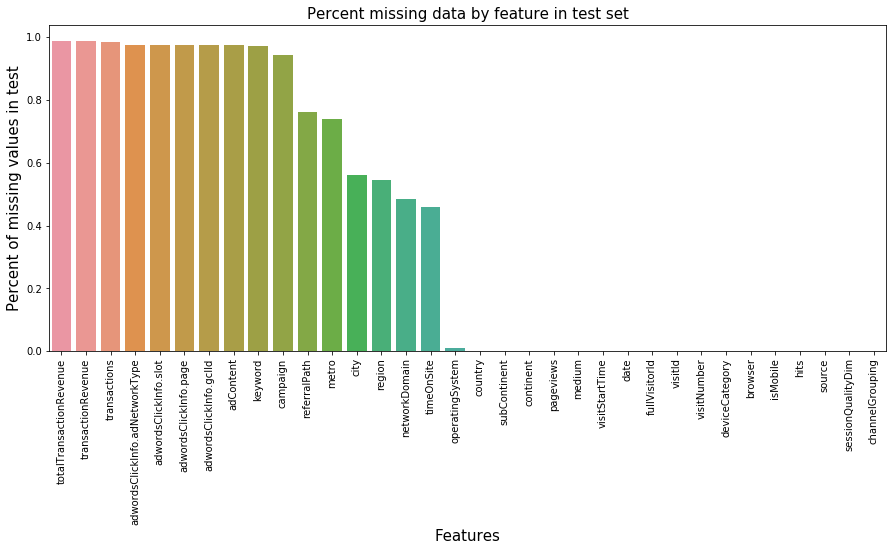

In [0]:
total = final_test.isnull().sum().sort_values(ascending=False)
percent = (final_test.isnull().sum()/final_test.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
f, ax = plt.subplots(figsize=(15, 6))
plt.xticks(rotation='90')
sns.barplot(x=missing_data.index, y=missing_data['Percent'])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values in test', fontsize=15)
plt.title('Percent missing data by feature in test set', fontsize=15)
missing_data.head(20)

**In the above bar graph we can see how much data is missing in test set features. almost 98 % data is missing in transaction, transaction revenue & total transaction revenue. Also, missing percentage in features is quite same in train and test set** 

In [0]:
final_train.columns.values

array(['channelGrouping', 'date', 'fullVisitorId', 'visitId',
       'visitNumber', 'visitStartTime', 'browser', 'operatingSystem',
       'isMobile', 'deviceCategory', 'continent', 'subContinent',
       'country', 'region', 'metro', 'city', 'networkDomain', 'hits',
       'pageviews', 'sessionQualityDim', 'timeOnSite', 'transactions',
       'transactionRevenue', 'totalTransactionRevenue', 'campaign',
       'source', 'medium', 'keyword', 'referralPath', 'adContent',
       'adwordsClickInfo.page', 'adwordsClickInfo.slot',
       'adwordsClickInfo.gclId', 'adwordsClickInfo.adNetworkType'],
      dtype=object)

In [0]:
# Save this preprocessed data
final_train.to_csv("drive/My Drive/GA_customer_revenue_prediction/final_train_preprocessed_v2.csv")
final_test.to_csv("drive/My Drive/GA_customer_revenue_prediction/final_test_preprocessed_v2.csv")

<h2><font color='red'>Exploratory data analysis

https://medium.com/@mvschamanth/predicting-how-much-customers-will-spend-at-gstore-c16d25a06e01

In [0]:
train_data=pd.read_csv('drive/My Drive/GA_customer_revenue_prediction/final_train_preprocessed_v2.csv',dtype={'fullVisitorId': 'str'})
test_data=pd.read_csv('drive/My Drive/GA_customer_revenue_prediction/final_test_preprocessed_v2.csv',dtype={'fullVisitorId': 'str'})

In [0]:
# The transaction revenue column is multiplied by 1,000,000 and so Divide transactionRevenue by 1,000,000
# The NaN values in target variable represent that visitor in particular visit didn't buy anything
# so replace NaN by 0
train_data["totalTransactionRevenue"].replace(np.nan,0,inplace=True)
train_data["totalTransactionRevenue"]=train_data["totalTransactionRevenue"].astype('float')
train_data["totalTransactionRevenue"]=train_data["totalTransactionRevenue"].div(1000000)
# we are predicting log(revenue per customer)
#We generally prefer logarithms to reduce exponentiality.
train_data["totalTransactionRevenue"] = train_data["totalTransactionRevenue"].apply(np.log1p)

In [0]:
test_data["totalTransactionRevenue"].replace(np.nan,0,inplace=True)
test_data["totalTransactionRevenue"]=test_data["totalTransactionRevenue"].astype('float')
test_data["totalTransactionRevenue"]=test_data["totalTransactionRevenue"].div(1000000)
# we are predicting log(revenue per customer)
#We generally prefer logarithms to reduce exponentiality.
test_data["totalTransactionRevenue"] = test_data["totalTransactionRevenue"].apply(np.log1p)

In [0]:
# setting the column as pandas datetime
train_data["date"] = pd.to_datetime(train_data["date"], format="%Y%m%d") 

we see three transactions related columns i.e. "totalTransactionRevenue","transactionRevenue" & "transactions". Let's understannd the difference between them in train and test as well

Of course, most users conduct just one transaction per visit (if any at all), in this case there is no difference between transactionRevenue and totalTransactionRevenue.

the field transactionRevenue corresponds only to the revenue resulting from one certain transaction during a visit, whereas totalTransactionRevenue represents the whole revenue resulting from the whole visit.

In [0]:
#print(train_data['totalTransactionRevenue'].nunique())
print(test_data['totalTransactionRevenue'].nunique())

2462


In [0]:
# this feature doesn't make sense as it gives value for one transaction only during visit
#print(train_data['transactionRevenue'].nunique())
print(test_data['transactionRevenue'].nunique())

1950


In [0]:
# number of transactions per visit
print(train_data['transactions'].value_counts())
print(test_data['transactions'].nunique())
print(test_data['transactions'].value_counts())

1.0     18048
2.0       420
3.0        43
4.0        17
5.0        11
6.0         6
7.0         5
8.0         3
12.0        2
25.0        1
21.0        1
15.0        1
10.0        1
Name: transactions, dtype: int64
7
1.0    6151
2.0     141
3.0       4
5.0       3
4.0       3
6.0       2
9.0       1
Name: transactions, dtype: int64


In [0]:
#EDA is practice of iteratively asking a series of questions about the data and trying to build hypotheses based on the insights you gain from data.
print("Number of unique visitors in train set : ",train_data.fullVisitorId.nunique(), " out of rows : ",train_data.shape[0])
print("Number of unique visitors in test set : ",test_data.fullVisitorId.nunique(), " out of rows : ",test_data.shape[0])

Number of unique visitors in train set :  1323730  out of rows :  1708337
Number of unique visitors in test set :  296530  out of rows :  401589


In [0]:
# explore the target variable , total revenue by each customer
# https://www.geeksforgeeks.org/python-pandas-dataframe-groupby/
temp = train_data.groupby("fullVisitorId")
temp_te=test_data.groupby("fullVisitorId")

In [0]:
print(temp.first())

                     Unnamed: 0  ... adwordsClickInfo.adNetworkType
fullVisitorId                    ...                               
0000000259678714014      680923  ...                            NaN
0000010278554503158      379656  ...                            NaN
0000020424342248747      168926  ...                            NaN
0000027376579751715     1260547  ...                            NaN
0000039460501403861     1193591  ...                            NaN
...                         ...  ...                            ...
999997550040396460      1505477  ...                            NaN
9999978264901065827     1132625  ...                            NaN
9999985820452794361     1092080  ...                            NaN
9999986437109498564      256613  ...                            NaN
9999997304197521748      988316  ...                            NaN

[1323730 rows x 34 columns]


In [0]:
temp1=temp["totalTransactionRevenue"].sum().reset_index()
temp1_te=temp_te["totalTransactionRevenue"].sum().reset_index()
# temp1 will contain visitor and total revenue generated by that visitor

In [0]:
temp1.describe

<bound method NDFrame.describe of                fullVisitorId  totalTransactionRevenue
0        0000000259678714014                      0.0
1        0000010278554503158                      0.0
2        0000020424342248747                      0.0
3        0000027376579751715                      0.0
4        0000039460501403861                      0.0
...                      ...                      ...
1323725   999997550040396460                      0.0
1323726  9999978264901065827                      0.0
1323727  9999985820452794361                      0.0
1323728  9999986437109498564                      0.0
1323729  9999997304197521748                      0.0

[1323730 rows x 2 columns]>

In [0]:
temp1['totalTransactionRevenue'].describe()

count    1.323730e+06
mean     5.805487e-02
std      6.717374e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.835310e+02
Name: totalTransactionRevenue, dtype: float64

we can see in the above table that 75th percentile is even 0. Means 75% of customers just visited and didn't make any transaction, Let's explore more percentiles

In [0]:
#looking further from the 75th percecntile
for i in range(75,100):
    var =temp1['totalTransactionRevenue'].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

75 percentile value is 0.0
76 percentile value is 0.0
77 percentile value is 0.0
78 percentile value is 0.0
79 percentile value is 0.0
80 percentile value is 0.0
81 percentile value is 0.0
82 percentile value is 0.0
83 percentile value is 0.0
84 percentile value is 0.0
85 percentile value is 0.0
86 percentile value is 0.0
87 percentile value is 0.0
88 percentile value is 0.0
89 percentile value is 0.0
90 percentile value is 0.0
91 percentile value is 0.0
92 percentile value is 0.0
93 percentile value is 0.0
94 percentile value is 0.0
95 percentile value is 0.0
96 percentile value is 0.0
97 percentile value is 0.0
98 percentile value is 0.0
99 percentile value is 3.218475744846861
100 percentile value is  183.5310019152003


from the above analysis , we can say that 98% of the customers didn't make any transaction at all. Only 2% customers are actually purchasing the stuff from GStore.

In [0]:
#looking further from the 99th percecntile
for i in np.arange(99,100,0.1):
    var =temp1['totalTransactionRevenue'].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

99.0 percentile value is 3.218475744846861
99.1 percentile value is 3.427514689979529
99.19999999999999 percentile value is 3.6423118182976015
99.29999999999998 percentile value is 3.8413859258287055
99.39999999999998 percentile value is 4.037244970181528
99.49999999999997 percentile value is 4.248352374701448
99.59999999999997 percentile value is 4.522874943261261
99.69999999999996 percentile value is 4.867534450455582
99.79999999999995 percentile value is 5.539025749041718
99.89999999999995 percentile value is 7.349590888399952
100 percentile value is  183.5310019152003


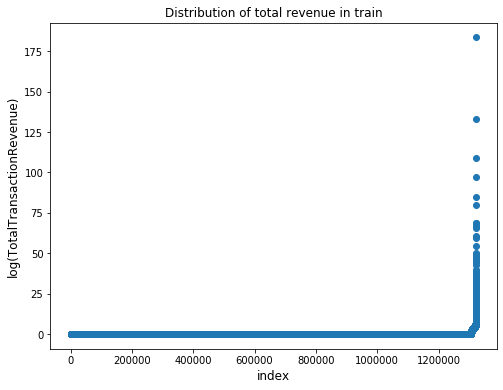

In [0]:
# Exploring the revenue values
plt.figure(figsize=(8,6))
plt.scatter(range(temp1.shape[0]), np.sort(temp1["totalTransactionRevenue"].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('log(TotalTransactionRevenue)', fontsize=12)
plt.title('Distribution of total revenue in train')
plt.show()

it is clearly visible that out of 1323730 customers, approx 1300000 didn't buy anything(total transaction revenue = 0) 

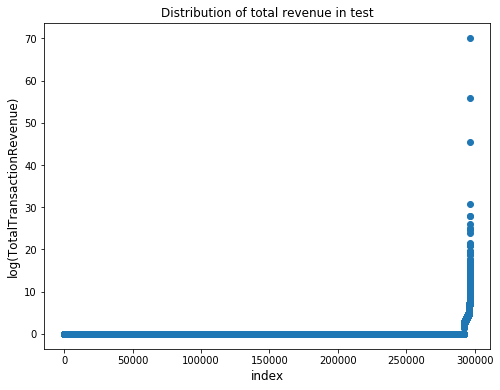

In [0]:
# Exploring the revenue values in test
plt.figure(figsize=(8,6))
plt.scatter(range(temp1_te.shape[0]), np.sort(temp1_te["totalTransactionRevenue"].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('log(TotalTransactionRevenue)', fontsize=12)
plt.title('Distribution of total revenue in test')
plt.show()

it is clearly visible that out of 401589 customers, approx 280000 didn't buy anything(total transaction revenue = 0)

[Text(0, 0.5, 'probability'), Text(0.5, 0, 'log (TotalTransactionRevenue)')]

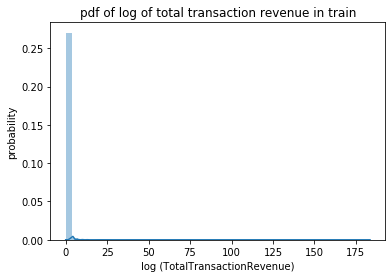

In [0]:
# pdf of log of total transaction revenue
ax=sns.distplot(temp1["totalTransactionRevenue"])
ax.set_title('pdf of log of total transaction revenue in train')
ax.set(xlabel='log (TotalTransactionRevenue)', ylabel='probability')

Distribution of total transaction Revenues by customer is not normal( as expected)

In [0]:
from scipy.stats import kurtosis, skew
total = temp1["totalTransactionRevenue"]
print("The skewness of the transaction value ", skew(total))
print("The kurtosis of the transaction value ", kurtosis(total))

The skewness of the transaction value  47.87968918124291
The kurtosis of the transaction value  7439.139991512002


[Text(0, 0.5, 'probability'), Text(0.5, 0, 'log (TotalTransactionRevenue)')]

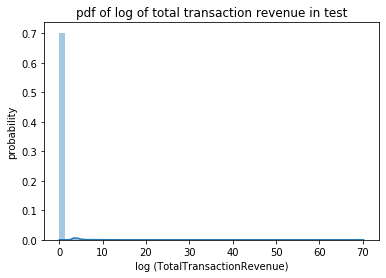

In [0]:
# pdf of log of total transaction revenue in test
ax=sns.distplot(temp1_te["totalTransactionRevenue"])
ax.set_title('pdf of log of total transaction revenue in test')
ax.set(xlabel='log (TotalTransactionRevenue)', ylabel='probability')

In [0]:
total = temp1_te["totalTransactionRevenue"]
print("The skewness of the transaction value ", skew(total))
print("The kurtosis of the transaction value ", kurtosis(total))

The skewness of the transaction value  20.20448086183111
The kurtosis of the transaction value  1103.0101390800899


<h1><font color='blue'>Univariate analysis

<h2><font color='blue'>Revenue & Visits by Date features

            count      mean
date                       
2016-08-01   1711  0.083645
2016-08-02   2140  0.032731
2016-08-03   2890  0.000000
2016-08-04   3161  0.020088
2016-08-05   2702  0.066113
...           ...       ...
2018-04-26   3177  0.034895
2018-04-27   2626  0.029761
2018-04-28   1972  0.015652
2018-04-29   1977  0.028217
2018-04-30   2753  0.059495

[638 rows x 2 columns]


Text(0.5, 1.0, 'Total Visits by date')

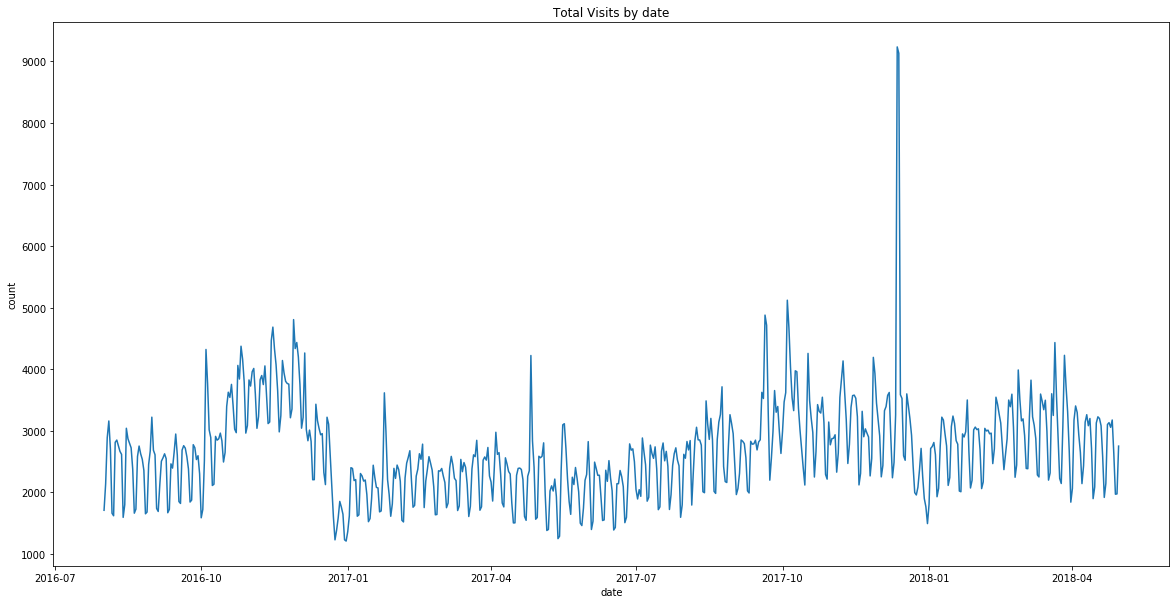

In [0]:
plt.figure(figsize=(20, 10))
# how the target variable is behaving with respect to 
a = train_data.loc[:,['date', 'totalTransactionRevenue']]#extracting date column and target variable into separate df
cnt_srs = a.groupby('date')['totalTransactionRevenue'].agg(['count','mean'])# group by date & apply aggregation func on transaction revenue column
print(cnt_srs)
cnt_srs.columns = ["count", "mean transaction value"]
cnt_srs = cnt_srs.sort_values(by="date", ascending=False)
sns.lineplot(cnt_srs.index[:], cnt_srs['count'])
plt.title('Total Visits by date')

in 2016 most visits happened between october to december. then in year of 2017 most visits happened between october to december as compared to other month of 2017

Text(0.5, 1.0, 'Mean Revenue by date')

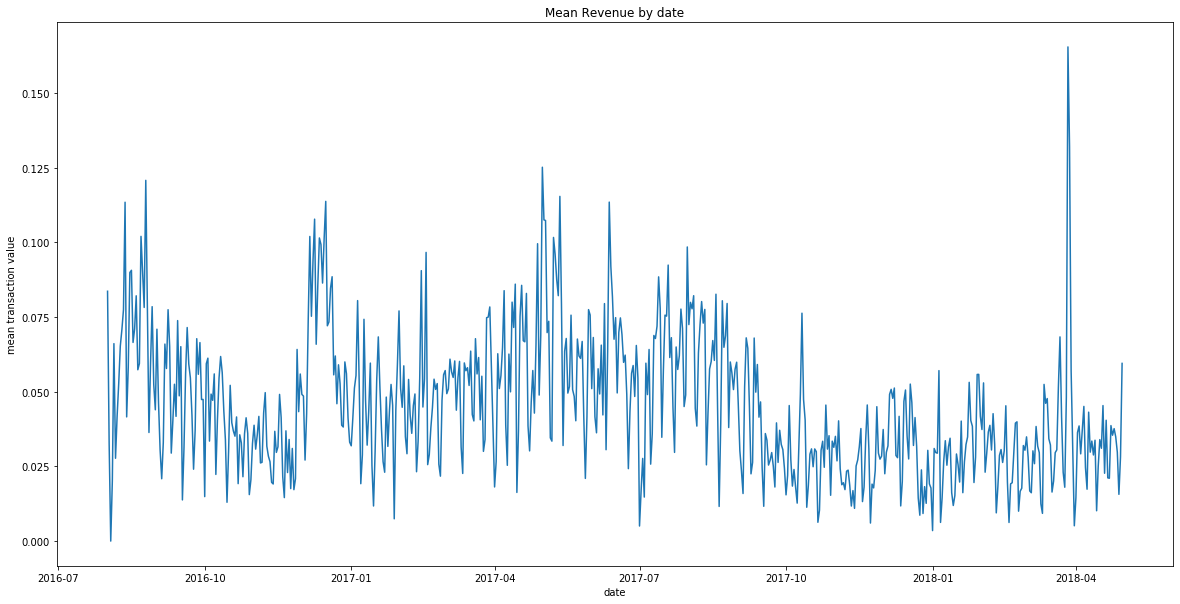

In [0]:
plt.figure(figsize=(20, 10))
sns.lineplot(cnt_srs.index[:], cnt_srs['mean transaction value'])
plt.title('Mean Revenue by date')

visits between october to december were highest but revenue in these months is lower as compared to other months of 2016 & 2017. In 2018 march highest revenue was generated.

Feature enginnering of "Date" and "visitStarttime" feature

In [0]:
# plotting date vs visits or revenue is not helping to draw any conclusions so we will do yearwise, monthwise, weekwise,daywise & hourwise analysis
from datetime import datetime

# This function is to extract date features
def date_process(df):
    df["date"] = pd.to_datetime(df["date"], format="%Y%m%d") # seting the column as pandas datetime
    df["_weekday"] = df['date'].dt.weekday #extracting week day
    df["_day"] = df['date'].dt.day # extracting day
    df["_month"] = df['date'].dt.month # extracting day
    df["_year"]=df['date'].dt.year # extracting day
    df['_visitHour'] = (df['visitStartTime'].apply(lambda x: str(datetime.fromtimestamp(x).hour))).astype(int)
    
    return df #returning the df after the transformations

In [0]:
data=date_process(train_data)
data_test=date_process(test_data)

Text(0.5, 1.0, 'Revenue by week day in train')

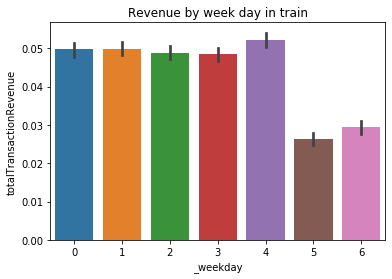

In [0]:
# which week day is giving most revenue
# 0 means monday here
sns.barplot(x=data['_weekday'], y=data['totalTransactionRevenue'], data=data).set_title('Revenue by week day in train')

Revenue in weekends (sat & sun) is quite low because people mostly go out on weekends

Text(0.5, 1.0, 'Revenue by week day in test')

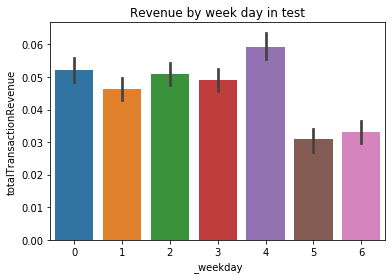

In [0]:
sns.barplot(x=data_test['_weekday'], y=data_test['totalTransactionRevenue'], data=data_test).set_title('Revenue by week day in test')

Revenue during weekends (sat & sun) is quite low because people mostly go out on weekends

Text(0.5, 1.0, 'Revenue by calender day in train')

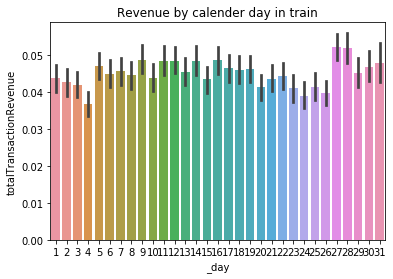

In [0]:
# which calender day is giving most revenue
sns.barplot(x=data['_day'], y=data['totalTransactionRevenue'], data=data).set_title('Revenue by calender day in train')

revenue on 27 and 28 is highest maybe because salary credited on these dates.lowest revenue is on 4th calender day. otherwise there is not any pattern for revenue based on calender days.

Text(0.5, 1.0, 'Revenue by calender day in test')

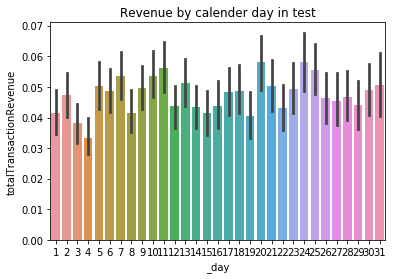

In [0]:
# which calender day is giving most revenue
sns.barplot(x=data_test['_day'], y=data_test['totalTransactionRevenue'], data=data_test).set_title('Revenue by calender day in test')

in test set calender day is not giving any pattern based on revenue, except that lowest revenue is on 4th calender day.

Text(0.5, 1.0, 'Revenue by month in train')

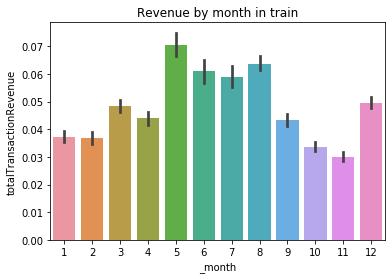

In [0]:
# in which month we got most revenue
sns.barplot(x=data['_month'], y=data['totalTransactionRevenue'], data=data).set_title('Revenue by month in train')

in may month we got most revenue, during may to august generated revenue is high as compared to other months.

Text(0.5, 1.0, 'Revenue by month in test')

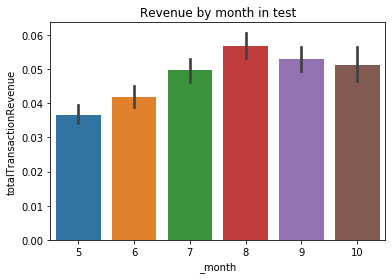

In [0]:
sns.barplot(x=data_test['_month'], y=data_test['totalTransactionRevenue'], data=data_test).set_title('Revenue by month in test')

in test we don't have information about all months. But in august revenue is highest. 

Text(0.5, 1.0, 'Revenue by year in train')

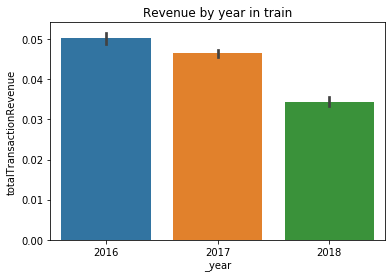

In [0]:
sns.barplot(x=data['_year'], y=data['totalTransactionRevenue'], data=data).set_title('Revenue by year in train')

in year 2016 revenue generated is highest

Text(0.5, 1.0, 'Revenue by year in test')

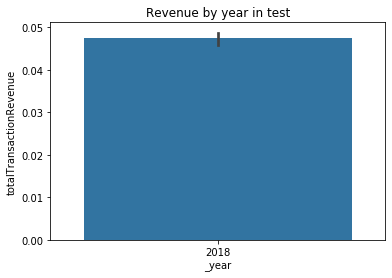

In [0]:
sns.barplot(x=data_test['_year'], y=data_test['totalTransactionRevenue'], data=data_test).set_title('Revenue by year in test')

Text(0.5, 1.0, 'Revenue by visit hours in train')

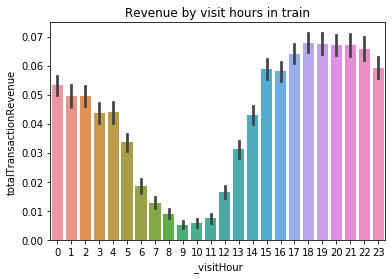

In [0]:
# during which hour of the day revenue is high generally
sns.barplot(x=data['_visitHour'], y=data['totalTransactionRevenue'], data=data).set_title('Revenue by visit hours in train')

this feature is certainly very usefull as there is clear pattern we can see. if visiting time is evening revenue is highest. in late morning very less revenue is generated obviously that's the time when people get ready for their work in weekdays or sleep on weekends

Text(0.5, 1.0, 'Revenue by visit hours in test')

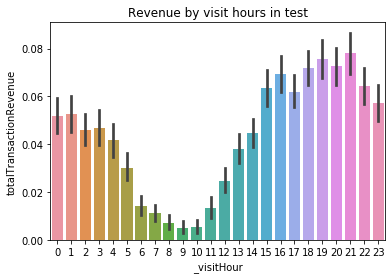

In [0]:
sns.barplot(x=data_test['_visitHour'], y=data_test['totalTransactionRevenue'], data=data_test).set_title('Revenue by visit hours in test')

clear pattern in test also, highest revenue in evening time,  this feature is very usefull

<h2><font color='blue'>Revenue & Visits by Categorical feature

In [0]:
train_data['adwordsClickInfo.adNetworkType'].nunique()

In [0]:
def plot_for_each_category(categorical_feature):
  '''this function will plot the count of number of data points(number of visits) lie in different categories of categorical features
  also, it will plot bar chart for mean transaction value for different categories of categorical feature'''
  a = train_data.loc[:,[categorical_feature, 'totalTransactionRevenue']]#extracting particular feature and target variable into separate df
  cnt_srs = a.groupby(categorical_feature)['totalTransactionRevenue'].agg(['count','mean'])# group by the categorical 
  cnt_srs.columns = ["count", "mean transaction value"]
  cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
  print(cnt_srs)
  plt.figure(figsize=(30,15)) 
  plt.subplot(4,1,1)
  plt.title('Number of visits by '+categorical_feature)
  sns.barplot(x=cnt_srs.index[:10], y=cnt_srs['count'].head(10))
  #print("----------------------------------------------------------------------")
  plt.subplots_adjust(hspace = 0.6)
  plt.subplot(4,1,2)# 3rd axis shouldn't be same as previous subplot
  cnt_srs = cnt_srs.sort_values(by="mean transaction value", ascending=False)
  plt.title('Mean transaction value by '+categorical_feature)
  sns.barplot(x=cnt_srs.index[:10], y=cnt_srs['mean transaction value'].head(10))

                  count  mean transaction value
channelGrouping                                
Organic Search   738963                0.029612
Social           354971                0.001709
Direct           273134                0.052246
Referral         211307                0.171466
Display           51283                0.018523
Paid Search       45627                0.062370
Affiliates        32915                0.001812
(Other)             137                0.018717


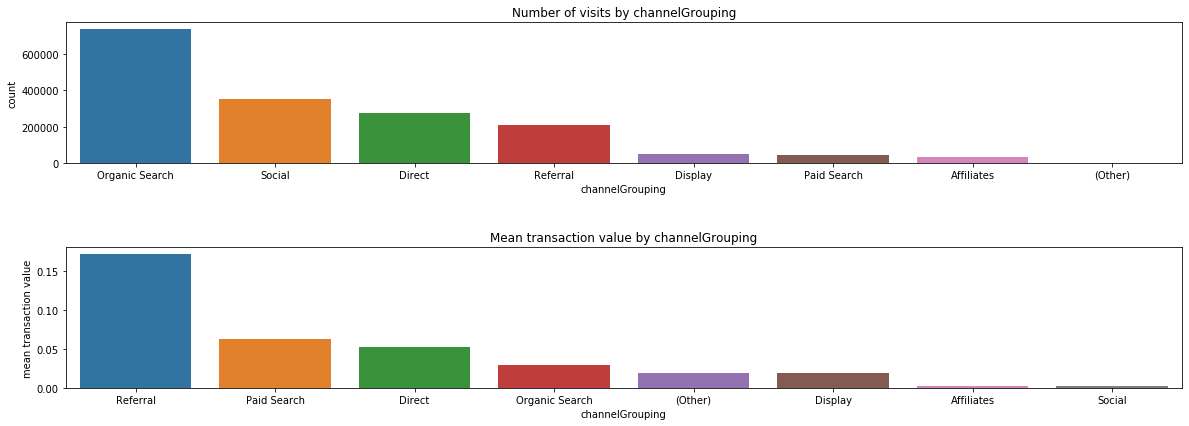

In [0]:
# feature: channel grouping(the channel via which user came to the store)
plot_for_each_category('channelGrouping')

Most of the vists happened when channel was Organic Search, then  Social & Direct.
 
Most revenue generated when channel was Referral.

                                                      count  mean transaction value
browser                                                                            
Chrome                                              1173056                0.059603
Safari                                               312165                0.014290
Firefox                                               63845                0.023066
Internet Explorer                                     35474                0.015938
Android Webview                                       34266                0.000886
...                                                     ...                     ...
;__CT_JOB_ID__:65da7e5f-0f05-4b5d-8d31-1f4d470a...        1                0.000000
;__CT_JOB_ID__:6e9dcf2f-f58f-4938-91e3-77e00868...        1                0.000000
;__CT_JOB_ID__:76fd1acb-e365-43c0-b967-908bcf5d...        1                0.000000
;__CT_JOB_ID__:7e575295-571e-4e82-9254-7f2c8bbb...        1                0

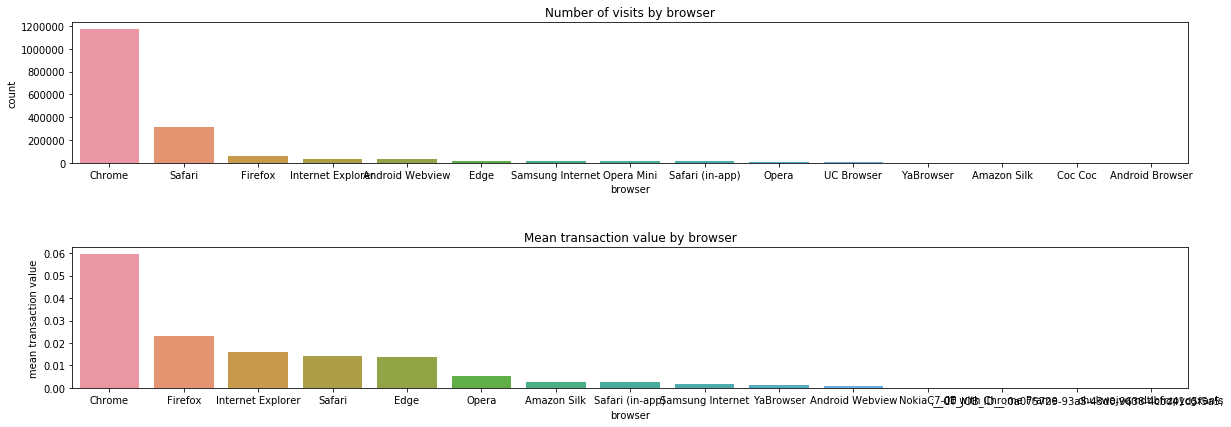

In [0]:
# feature: browser (the browser via which user came to the store)
plot_for_each_category('browser')

Most of the vists happened when browser was Chrome. (almost 90% visits)
Most revenue generated when browser was Chrome.
Firefox is the second in the browser list which generated higher revenue but not used by many people.

                   count  mean transaction value
operatingSystem                                 
Windows           619720                0.023656
Macintosh         438514                0.100169
Android           299386                0.009274
iOS               219334                0.013503
Linux              63971                0.077847
Chrome OS          51318                0.146959
Windows Phone       1675                0.001998
Samsung              911                0.000000
Tizen                709                0.000000
BlackBerry           350                0.000000
OS/2                 199                0.000000
Xbox                 133                0.000000
Nintendo Wii         100                0.000000
Firefox OS            97                0.000000
Nintendo WiiU         51                0.000000
FreeBSD               18                0.000000
Playstation Vita      15                0.000000
Nintendo 3DS           9                0.000000
OpenBSD             

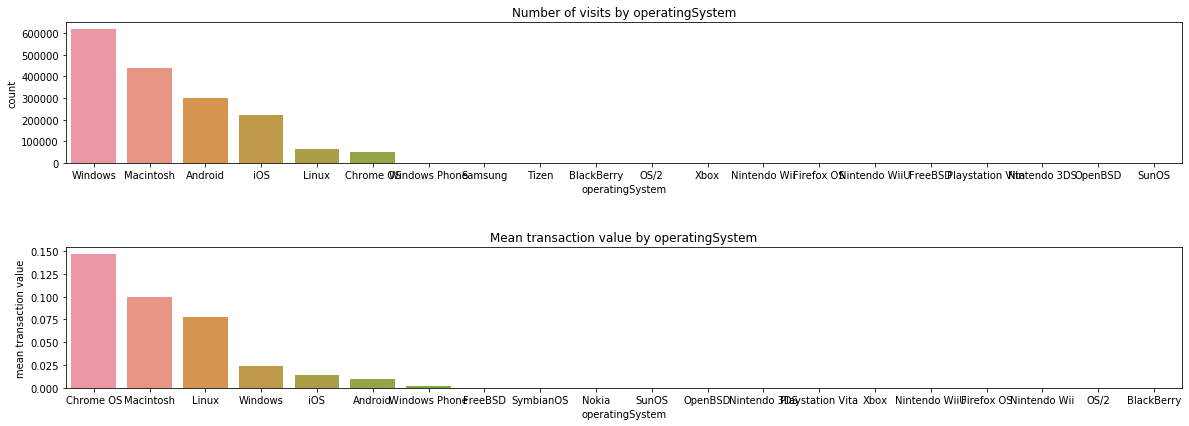

In [0]:
plot_for_each_category('operatingSystem')

large crowd use windows so most vists happened when os was windows, then macintost , android and ios.
But when OS was Chrome OS highest revenue was generated then Macintosh and linux generated higher revenue. 

            count  mean transaction value
isMobile                                 
False     1171670                0.060615
True       536667                0.010861


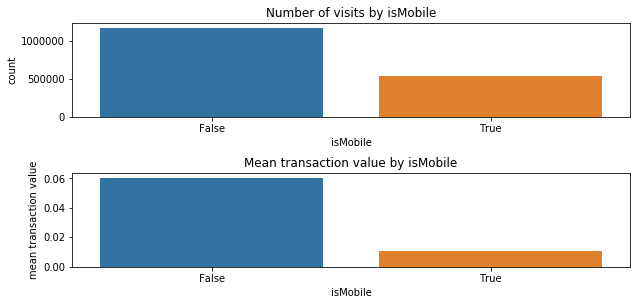

In [0]:
plot_for_each_category('isMobile')

Number of visits is greater when mobile was not used. Revenue generated is also greater when mobile was not used. 

                  count  mean transaction value
deviceCategory                                 
desktop         1171579                0.060621
mobile           471336                0.010400
tablet            65422                0.014138


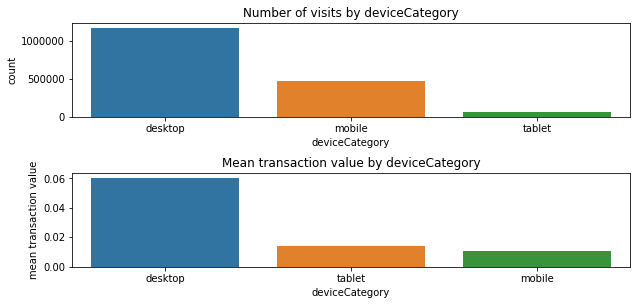

In [0]:
plot_for_each_category('deviceCategory')

people prefer using desktop for shopping

            count  mean transaction value
continent                                
Americas   877403                0.085820
Asia       396719                0.002032
Europe     368037                0.001393
Africa      35481                0.001817
Oceania     28180                0.004841


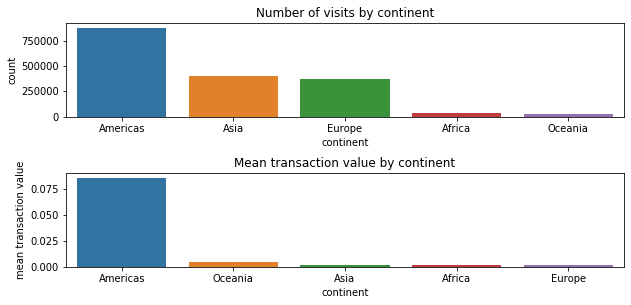

In [0]:
plot_for_each_category('continent')

Americans buy more from GStore than others

                     count  mean transaction value
subContinent                                      
Northern America    768345                0.096938
Southeast Asia      121634                0.002099
Southern Asia       121062                0.000671
Western Europe      115153                0.001767
Northern Europe     111693                0.001562
Eastern Asia         91072                0.003980
South America        75112                0.007888
Eastern Europe       74007                0.001047
Southern Europe      67184                0.000850
Western Asia         60966                0.001657
Central America      29564                0.005013
Australasia          27867                0.004895
Northern Africa      17255                0.000856
Western Africa        7086                0.002091
Southern Africa       6019                0.002070
Caribbean             4382                0.017453
Eastern Africa        4194                0.005343
Central Asia          1985     

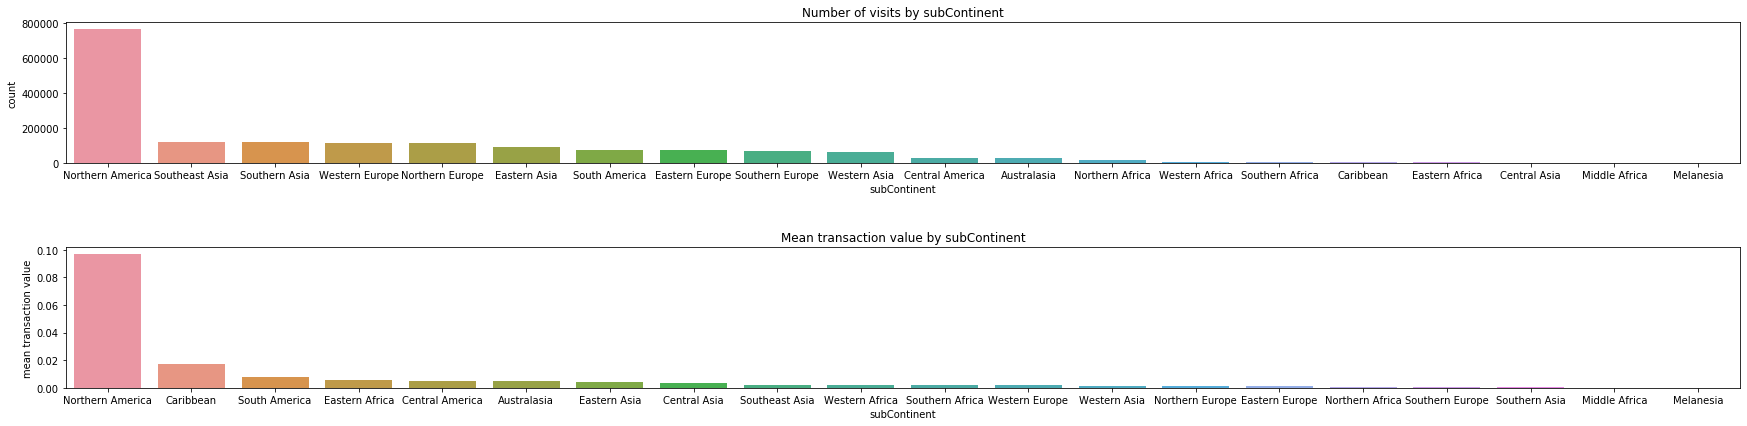

In [0]:
plot_for_each_category('subContinent')

we have seen americans buy more from GStore out of which North americans buy more

                        count  mean transaction value
country                                              
United States          717217                0.102067
India                  105317                0.000667
United Kingdom          73341                0.001425
Canada                  51057                0.025020
Germany                 38516                0.001234
...                       ...                     ...
St. Pierre & Miquelon       1                0.000000
Norfolk Island              1                0.000000
Solomon Islands             1                0.000000
Montserrat                  1                0.000000
Åland Islands               1                0.000000

[227 rows x 2 columns]


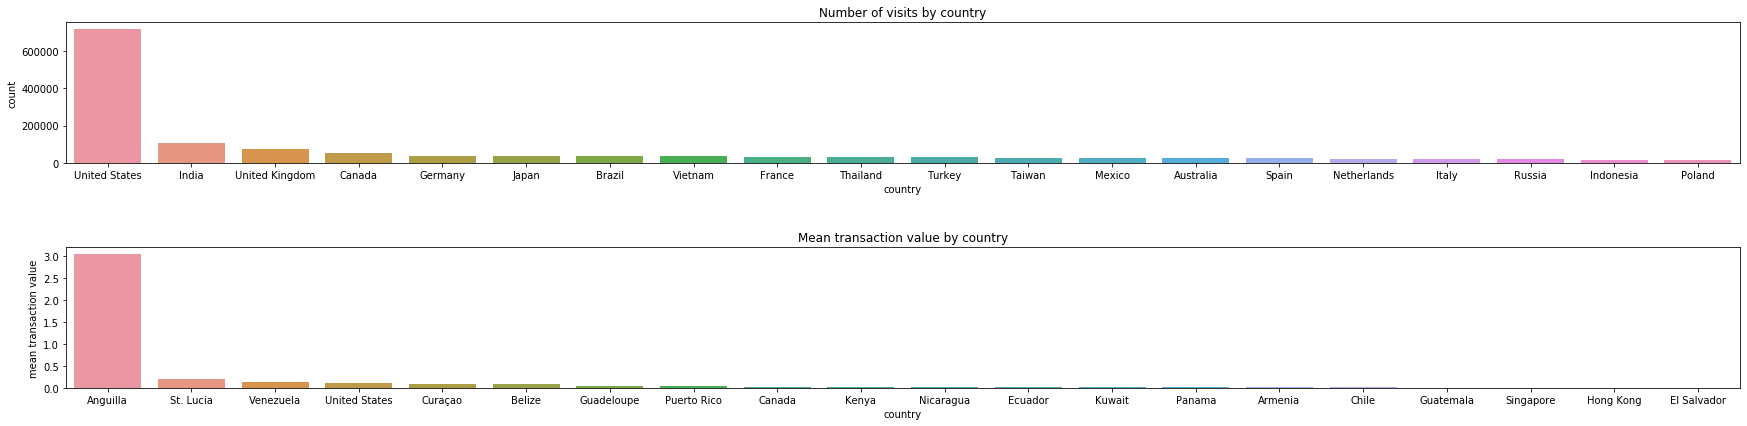

In [0]:
plot_for_each_category('country')

From United sates most people visited GStore and From anguilaa(island in north america) most revenue is generated. Anguilla people is target customers for marketing 

                      count  mean transaction value
region                                             
California           206669                0.112630
New York              49733                0.208588
England               25824                0.003028
Texas                 20480                0.101414
Washington            15372                0.136069
...                     ...                     ...
Gifu Prefecture           6                0.000000
Tyrol                     6                0.000000
Gharbia Governorate       6                0.000000
Abruzzo                   6                0.000000
Kumamoto Prefecture       5                0.000000

[481 rows x 2 columns]


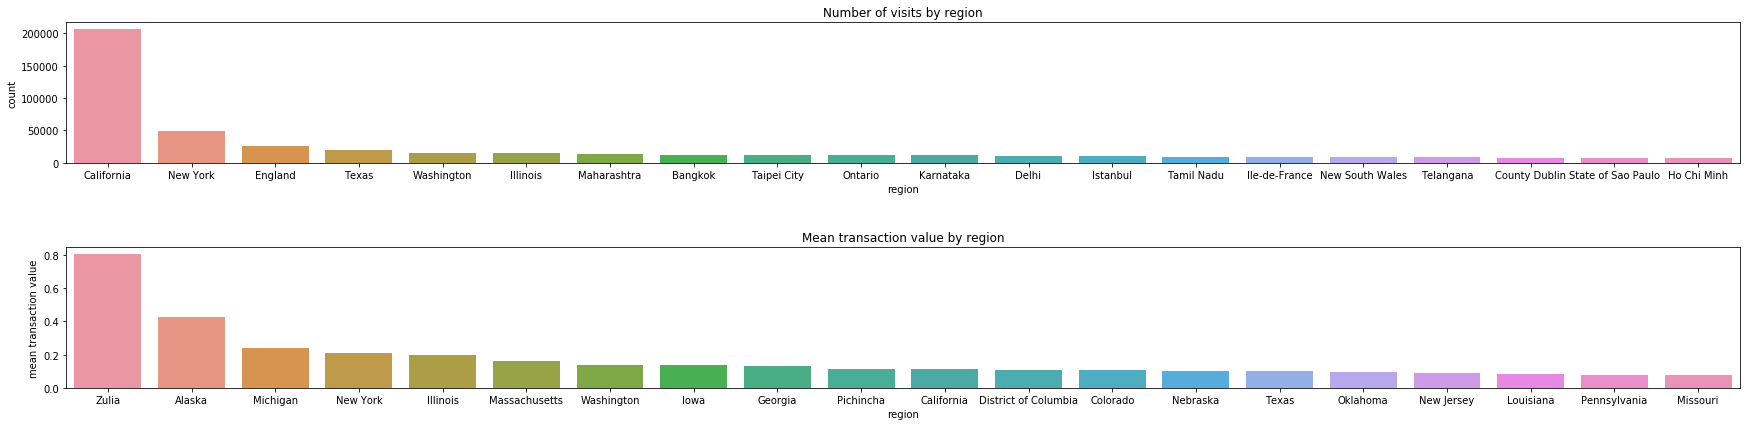

In [0]:
plot_for_each_category('region')

most visits happened from california. From India some visits are from Maharashtra, delhi & karnatka.
Zulia is the state from where higher revenue is generated.

                                    count  mean transaction value
metro                                                            
San Francisco-Oakland-San Jose CA  182745                0.111983
New York NY                         50419                0.207354
London                              23643                0.003308
Los Angeles CA                      19953                0.123082
Chicago IL                          15300                0.198341
...                                   ...                     ...
Tallahassee FL-Thomasville GA           6                0.000000
Des Moines-Ames IA                      6                0.000000
Dayton OH                               6                0.000000
Springfield-Holyoke MA                  6                0.000000
Buffalo NY                              5                0.000000

[121 rows x 2 columns]


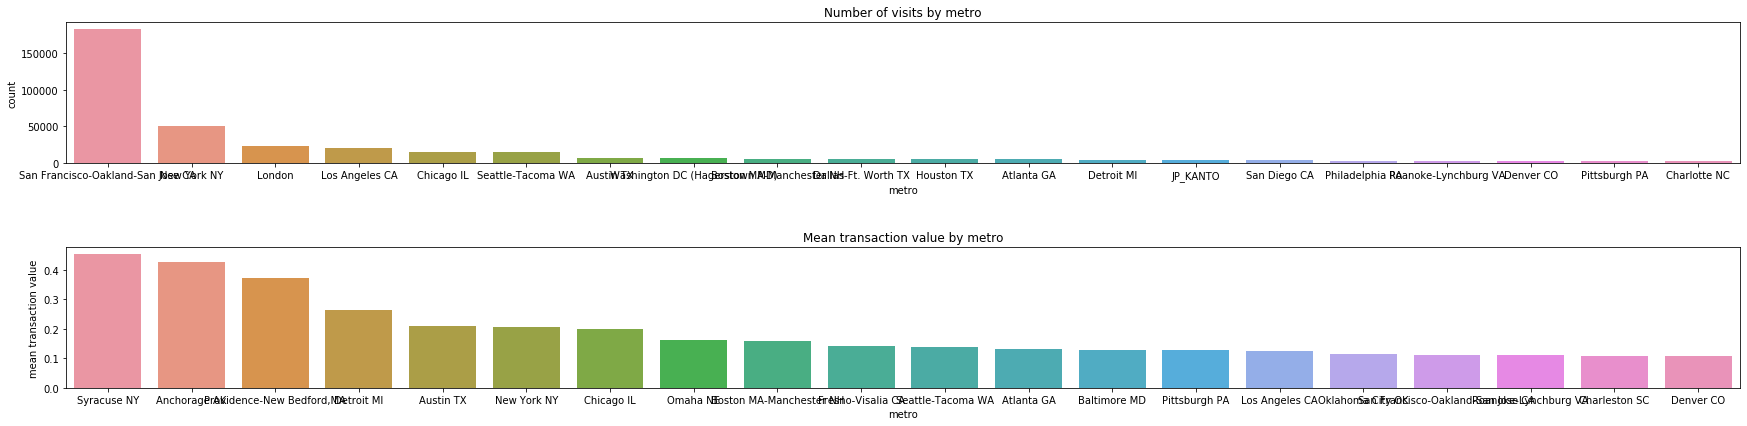

In [0]:
plot_for_each_category('metro')

from San Francisco-Oakland-San Jose CA most visits happened. And From Syracuse NY & Anchorage AK higher revenue was generated.

               count  mean transaction value
city                                        
Mountain View  74110                0.113671
New York       49460                0.209559
San Francisco  36960                0.130089
Sunnyvale      27923                0.122072
London         23622                0.003311
...              ...                     ...
Morgan Hill        4                0.000000
North Creek        4                0.000000
Daly City          4                0.000000
Chandler           3                0.000000
Boise              3                0.000000

[954 rows x 2 columns]


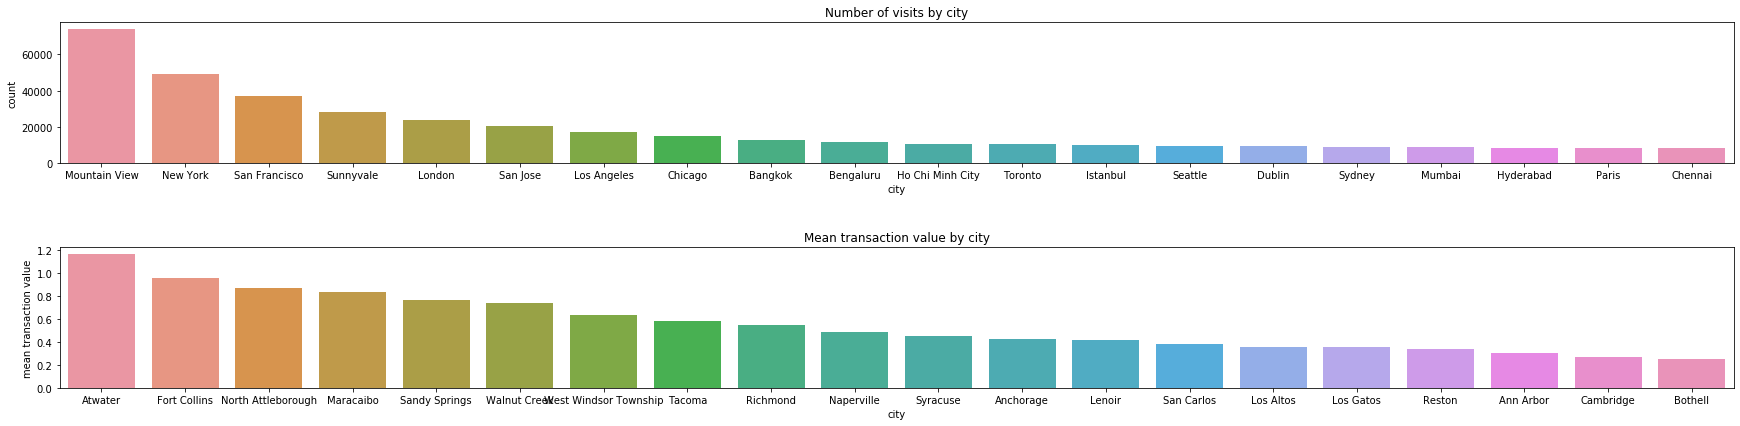

In [0]:
plot_for_each_category('city')

from Mountain View most visits happened. And From Atwater, Fort Collins & North Attleborough higher revenue was generated.

                     count  mean transaction value
networkDomain                                     
comcast.net          55486                0.111854
rr.com               28715                0.081990
verizon.net          26547                0.117076
ttnet.com.tr         17078                0.000192
comcastbusiness.net  16826                0.115355
...                    ...                     ...
omygods.com              1                0.000000
hochland.com             1                0.000000
broadlink.co.za          1                0.000000
broadlink.com.np         1                0.000000
buximedia.com            1                0.000000

[41980 rows x 2 columns]


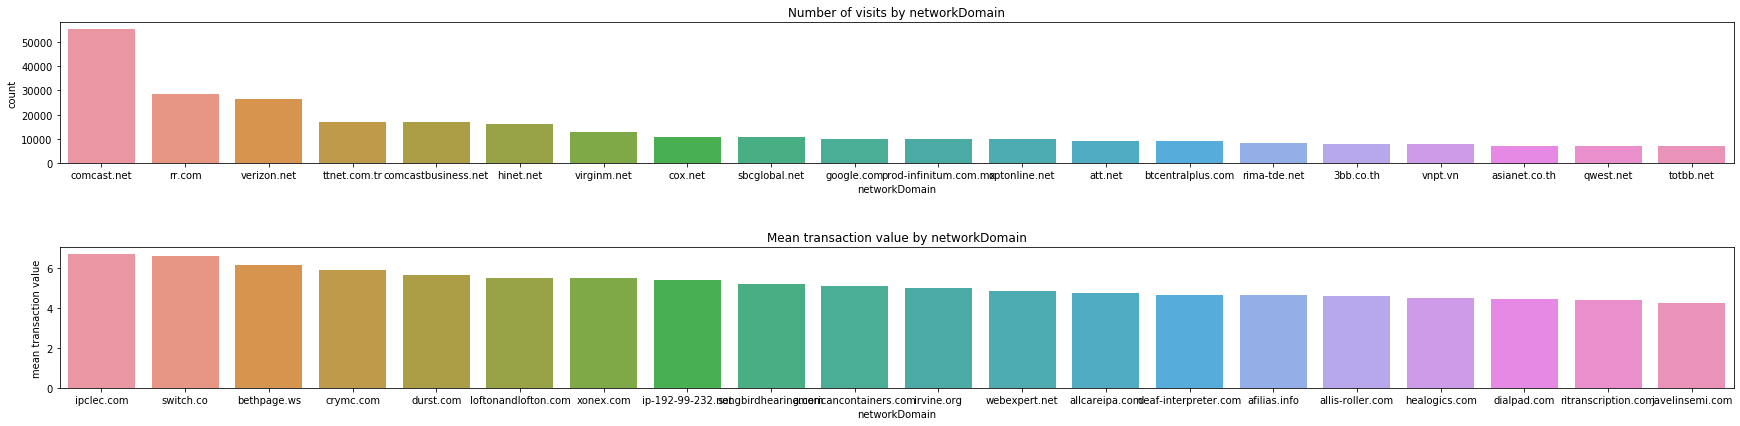

In [0]:
plot_for_each_category('networkDomain')

when network domain was comcast.net most visits happened and when network domain was ipclec.com or switch.co higher revenue was generated.

       count  mean transaction value
hits                                
1     864064                0.000000
2     237499                0.000136
3     134435                0.000193
4      80875                0.000730
5      63687                0.001732
...      ...                     ...
262        1                0.000000
260        1                0.000000
259        1                0.000000
204        1                5.138149
240        1                0.000000

[297 rows x 2 columns]


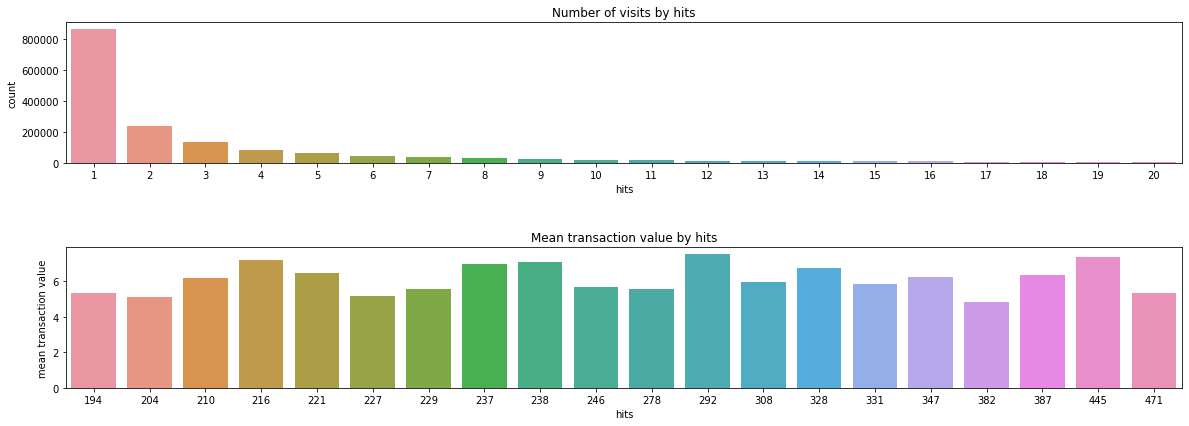

In [0]:
plot_for_each_category('hits')

number of hits is equal to 1 for most customers.mean transaction value by hits is not giving much insights.

            count  mean transaction value
pageviews                                
1.0        876328                0.000000
2.0        249794                0.000129
3.0        142896                0.000182
4.0         86666                0.000735
5.0         64712                0.002047
...           ...                     ...
213.0           1                0.000000
215.0           1                5.566281
162.0           1                0.000000
220.0           1                0.000000
500.0           1                0.000000

[230 rows x 2 columns]


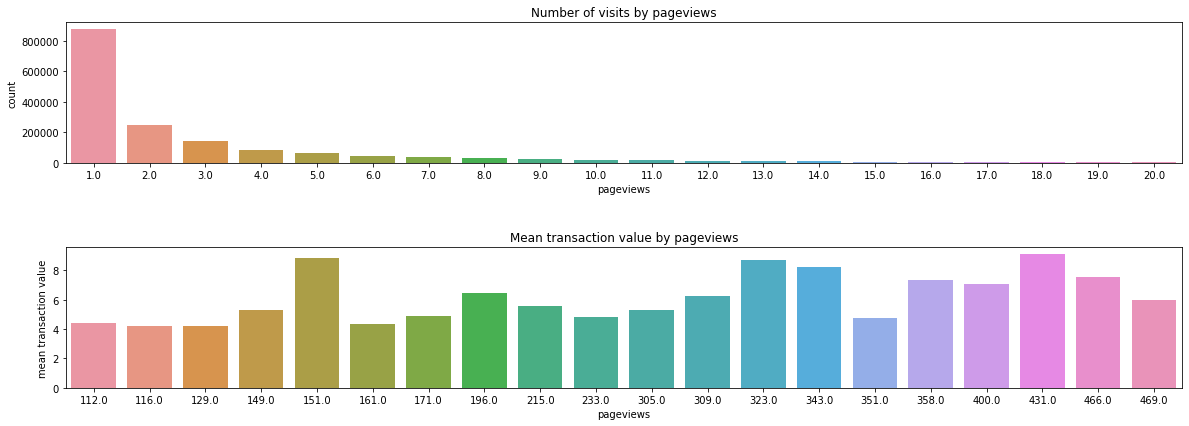

In [0]:
plot_for_each_category('pageviews')

most customers viewed only one page on GStore. mean transaction  by pageviews is not giving much insights.

               count  mean transaction value
visitNumber                                 
1            1307430                0.021921
2             182542                0.088605
3              70962                0.133183
4              37886                0.161148
5              23314                0.168059
...              ...                     ...
352                1                0.000000
403                1                0.000000
402                1                0.000000
401                1                0.000000
457                1                0.000000

[457 rows x 2 columns]


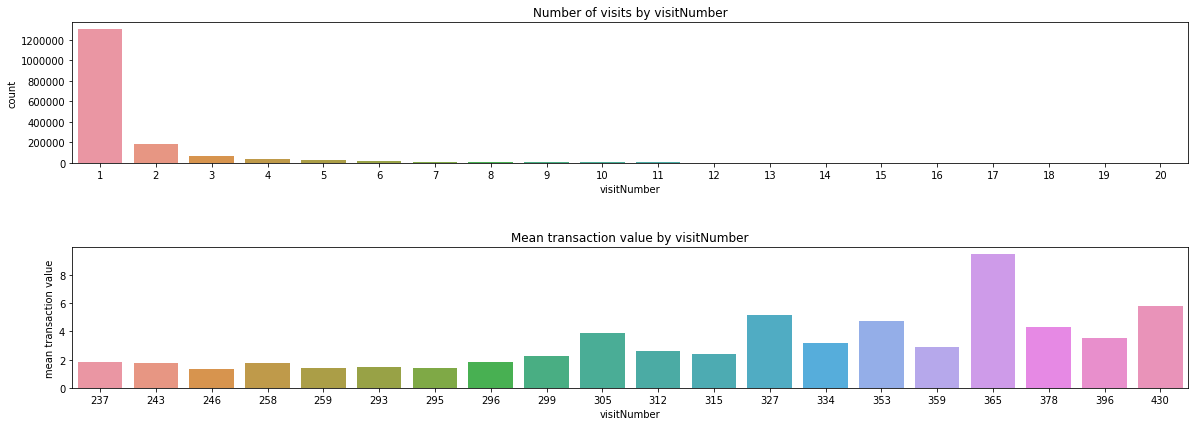

In [0]:
plot_for_each_category('visitNumber')

most of the customers visited only once. mean transaction revenue was high when customer visited 365 times at GStore.

                                                    count  mean transaction value
campaign                                                                         
Data Share Promo                                    32914                0.001812
1000557 | GA | US | en | Hybrid | GDN Text+Bann...  24410                0.000000
1000557 | GA | US | en | Hybrid | GDN Remarketing   15149                0.001079
AW - Dynamic Search Ads Whole Site                  15146                0.078858
AW - Accessories                                     7972                0.072292
Smart Display Campaign                               2664                0.000000
"google + redesign/Accessories March 17" All Us...   1179                0.000000
Page: contains "/google+redesign/drinkware" Sim...    611                0.000000
"google + redesign/Accessories March 17" All Users    562                0.038883
Sports & Fitness/Health & Fitness Buffs               463                0.000000
Run of Network L

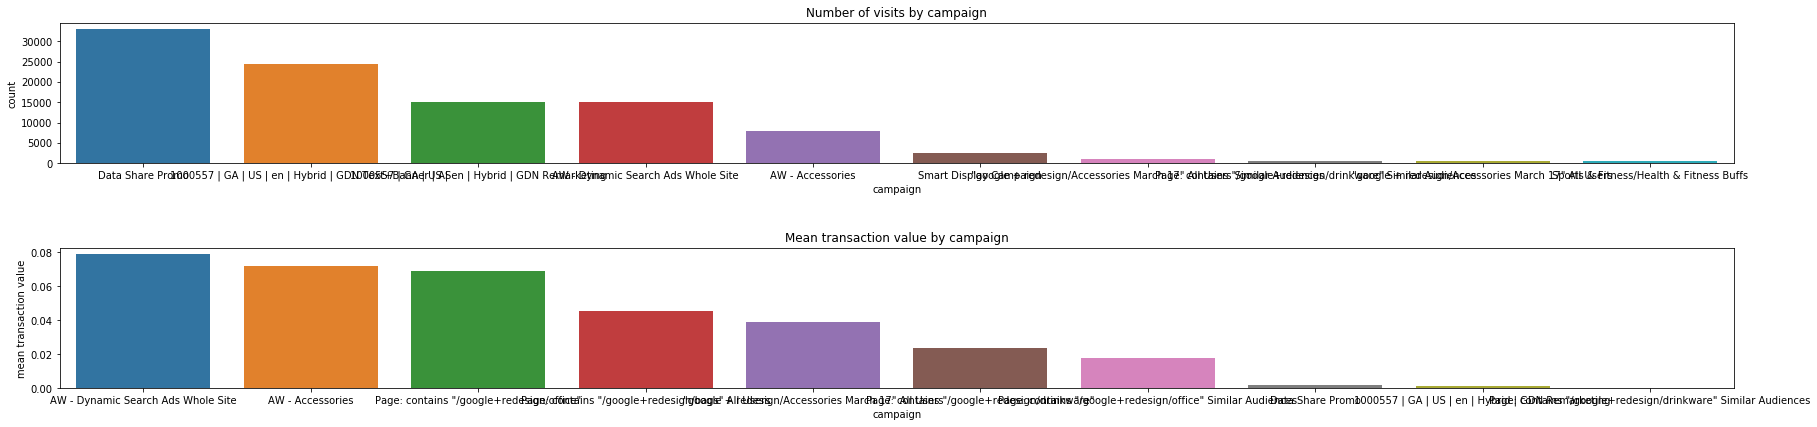

In [0]:
plot_for_each_category('campaign')

most visits happened when Campaign was 'Data Share promo'.
Revenue was higher when camaign was 'AW- dynamic search ads whole site', 'AW - Accessories' & "Page: contains "/google+redesign/drinkware"

                           count  mean transaction value
source                                                  
google                    658384                0.028414
(direct)                  565975                0.097591
youtube.com               329450                0.000232
analytics.google.com       37436                0.000212
Partners                   32931                0.001811
...                          ...                     ...
fr.yhs4.search.yahoo.com       1                0.000000
m.wikihow.com                  1                0.000000
cz.pinterest.com               1                0.000000
dailydot.com                   1                0.000000
id.pinterest.com               1                0.000000

[344 rows x 2 columns]


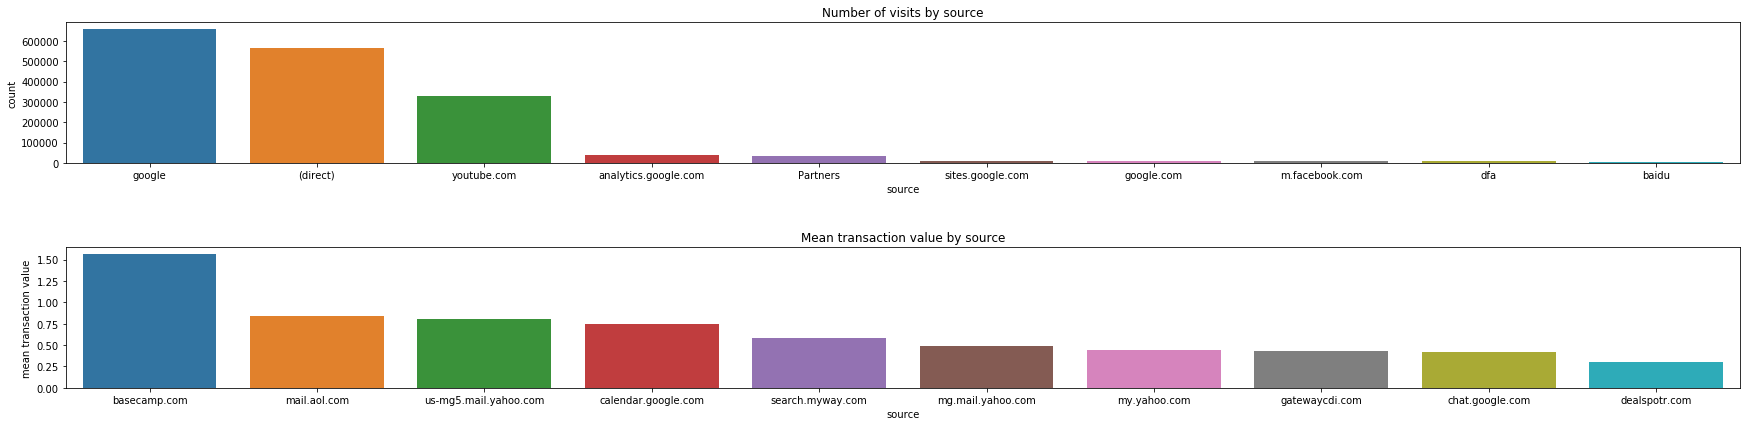

In [0]:
plot_for_each_category('source')

when source was google most visits occured and when source was basecamp.com highest revenue generated.

            count  mean transaction value
medium                                   
organic    591783                0.028257
(none)     565957                0.097594
referral   432963                0.004458
cpc         75603                0.026115
affiliate   32915                0.001812
cpm          8982                0.103120


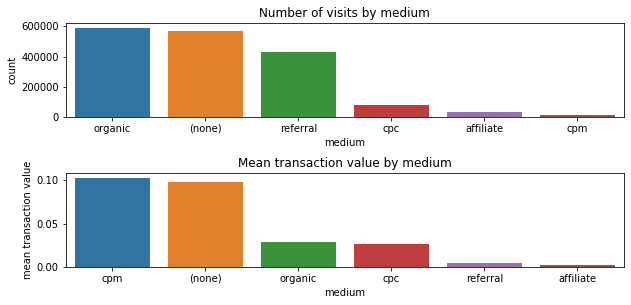

In [0]:
plot_for_each_category('medium')

organic medium causes more vists and cpm medium generated highest revenue. When medium was (none) visits and revenue both are high.

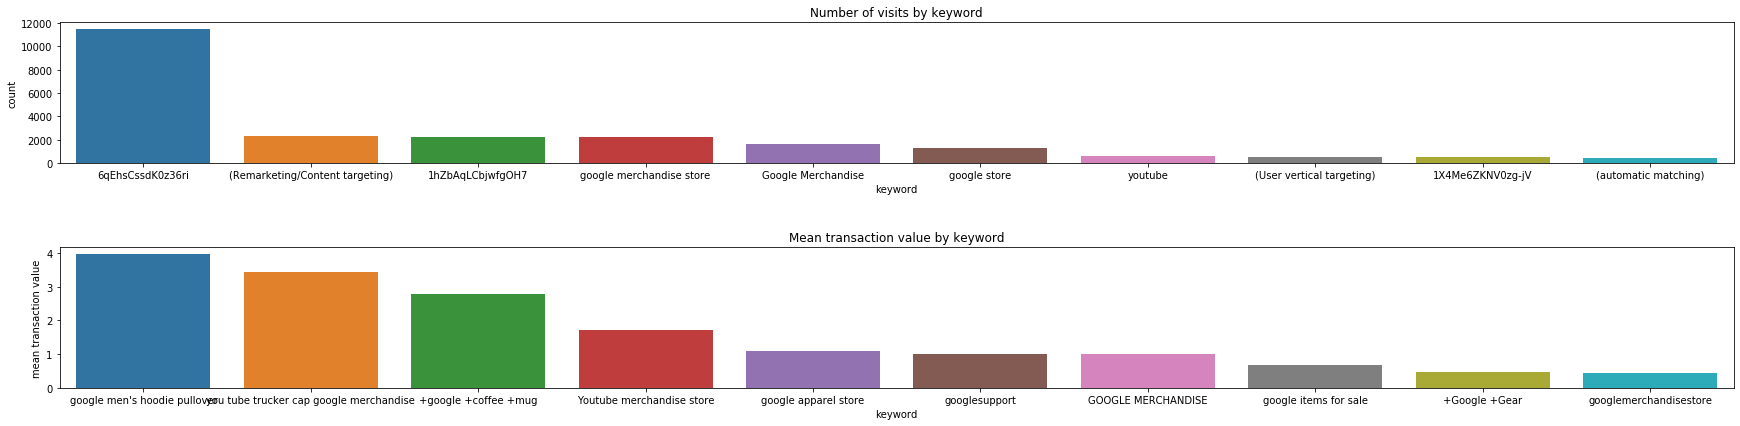

In [0]:
plot_for_each_category('keyword')

in around 2000 vists search keyword was google merchandise store.
when search keyword was "google men's hoodie pullover" highest revenue was generated.

                        count  mean transaction value
adwordsClickInfo.slot                                
RHS                     42750                0.000995
Top                     32447                0.080261
Google Display Network     77                0.000000


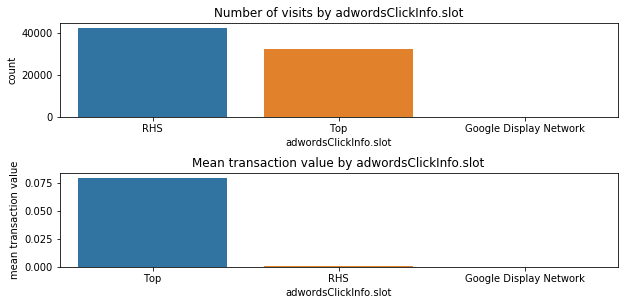

In [0]:
plot_for_each_category('adwordsClickInfo.slot')

                       count  mean transaction value
adwordsClickInfo.page                               
1.0                    73913                0.035809
2.0                     1057                0.000000
3.0                      172                0.000000
4.0                       80                0.000000
5.0                       30                0.000000
6.0                       10                0.000000
7.0                        6                0.000000
9.0                        3                0.000000
8.0                        1                0.000000
12.0                       1                0.000000
14.0                       1                0.000000


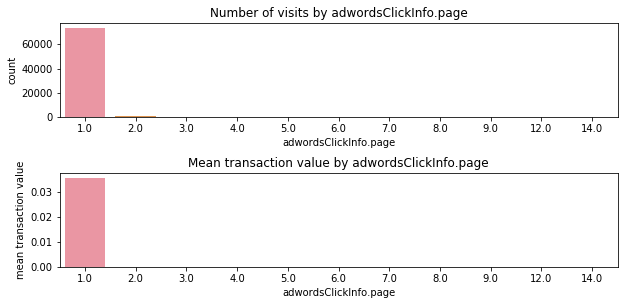

In [0]:
plot_for_each_category('adwordsClickInfo.page')

                                count  mean transaction value
adContent                                                    
Google Merchandise Store        39566                0.000413
Google Merchandise Collection    6762                0.093615
Placement Accessores 300 x 250   3040                0.007188
Smart display ad - 8/17/2017     2664                0.000000
Display Ad created 3/11/14       2344                0.014299
...                               ...                     ...
google store                        2                0.000000
GA Help Center                      1                0.000000
Swag w/ Google Logos                1                0.000000
Men's Apparel from Google           1                0.000000
Google Apparel                      1                0.000000

[76 rows x 2 columns]


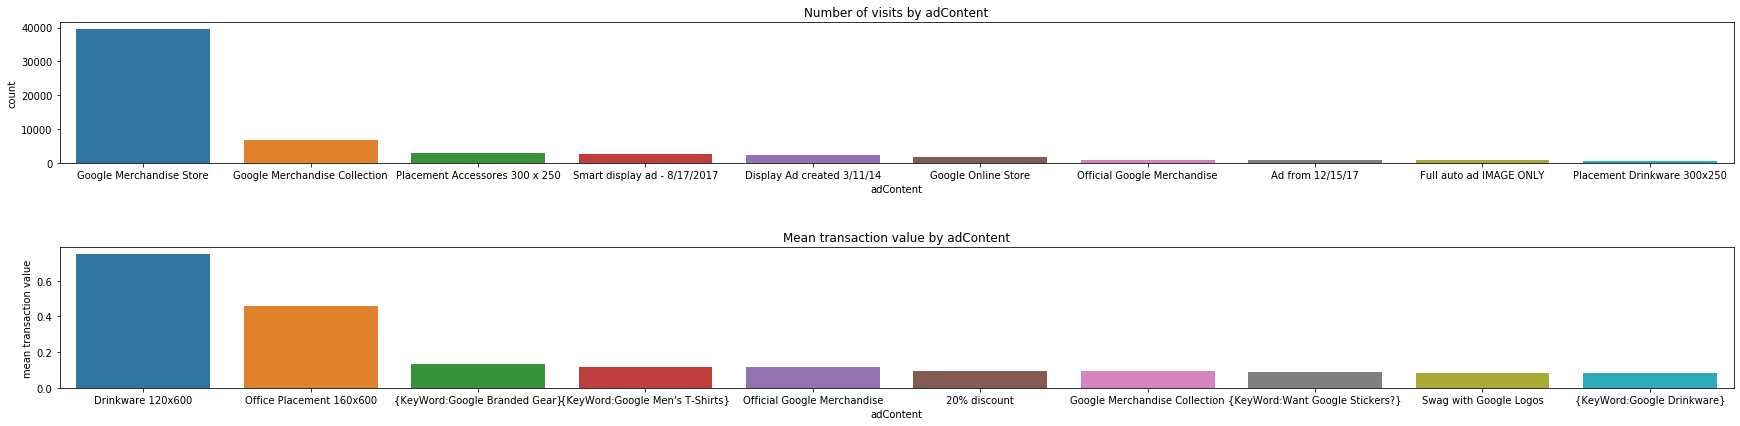

In [0]:
plot_for_each_category('adContent')

when adcontent was Drinkware 120*600 highest revenue was genearted.
most visits happened when adcontent was google merchandise store.

<h2><font color='red'>Featurization / Feature transformation



In [0]:
 # Handle categorical data
# Handle numerical data
drop_list=['Unnamed: 0','visitId','adwordsClickInfo.gclId','adwordsClickInfo.adNetworkType']
# drop columns which are not gonna help in revenue prediction
data.drop(drop_list,axis=1,inplace=True)
data_test.drop(drop_list,axis=1,inplace=True)

In [0]:
data_test.columns.values

array(['channelGrouping', 'date', 'fullVisitorId', 'visitNumber',
       'visitStartTime', 'browser', 'operatingSystem', 'isMobile',
       'deviceCategory', 'continent', 'subContinent', 'country', 'region',
       'metro', 'city', 'networkDomain', 'hits', 'pageviews',
       'timeOnSite', 'sessionQualityDim', 'transactions',
       'transactionRevenue', 'totalTransactionRevenue', 'referralPath',
       'campaign', 'source', 'medium', 'keyword', 'adContent',
       'adwordsClickInfo.page', 'adwordsClickInfo.slot', '_weekday',
       '_day', '_month', '_year', '_visitHour'], dtype=object)

In [0]:
data.columns.values

array(['channelGrouping', 'date', 'fullVisitorId', 'visitNumber',
       'visitStartTime', 'browser', 'operatingSystem', 'isMobile',
       'deviceCategory', 'continent', 'subContinent', 'country', 'region',
       'metro', 'city', 'networkDomain', 'hits', 'pageviews',
       'sessionQualityDim', 'timeOnSite', 'transactions',
       'transactionRevenue', 'totalTransactionRevenue', 'campaign',
       'source', 'medium', 'keyword', 'referralPath', 'adContent',
       'adwordsClickInfo.page', 'adwordsClickInfo.slot', '_weekday',
       '_day', '_month', '_year', '_visitHour'], dtype=object)

In [0]:
data.head()

,channelGrouping,date,fullVisitorId,visitNumber,visitStartTime,browser,operatingSystem,isMobile,deviceCategory,continent,subContinent,country,region,metro,city,networkDomain,hits,pageviews,sessionQualityDim,timeOnSite,transactions,transactionRevenue,totalTransactionRevenue,campaign,source,medium,keyword,referralPath,adContent,adwordsClickInfo.page,adwordsClickInfo.slot,_weekday,_day,_month,_year,_visitHour
0,Organic Search,2017-10-16,3162355547410993243,1,1508198450,Firefox,Windows,False,desktop,Europe,Western Europe,Germany,NaN,NaN,NaN,NaN,1,1.0,1.0,NaN,NaN,NaN,0.0,NaN,google,organic,water bottle,NaN,NaN,NaN,NaN,0,16,10,2017,0
1,Referral,2017-10-16,8934116514970143966,6,1508176307,Chrome,Chrome OS,False,desktop,Americas,Northern America,United States,California,San Francisco-Oakland-San Jose CA,Cupertino,NaN,2,2.0,2.0,28.0,NaN,NaN,0.0,NaN,sites.google.com,referral,NaN,/a/google.com/transportation/mtv-services/bike...,NaN,NaN,NaN,0,16,10,2017,17
2,Direct,2017-10-16,7992466427990357681,1,1508201613,Chrome,Android,True,mobile,Americas,Northern America,United States,NaN,NaN,NaN,windjammercable.net,2,2.0,1.0,38.0,NaN,NaN,0.0,NaN,(direct),(none),NaN,NaN,NaN,NaN,NaN,0,16,10,2017,0
3,Organic Search,2017-10-16,9075655783635761930,1,1508169851,Chrome,Windows,False,desktop,Asia,Western Asia,Turkey,NaN,NaN,NaN,NaN,2,2.0,1.0,1.0,NaN,NaN,0.0,NaN,google,organic,NaN,NaN,NaN,NaN,NaN,0,16,10,2017,16
4,Organic Search,2017-10-16,6960673291025684308,1,1508190552,Chrome,Windows,False,desktop,Americas,Central America,Mexico,NaN,NaN,NaN,prod-infinitum.com.mx,2,2.0,1.0,52.0,NaN,NaN,0.0,NaN,google,organic,NaN,NaN,NaN,NaN,NaN,0,16,10,2017,21


In [0]:
Categorical_columns=['channelGrouping','browser', 'operatingSystem', 'isMobile', 'deviceCategory', 'continent',
       'subContinent', 'country', 'region', 'metro', 'city','networkDomain',
        'source','campaign','medium', 'keyword','referralPath','adwordsClickInfo.slot','adContent']

In [0]:
Numerical_columns=['visitNumber','sessionQualityDim','timeOnSite','transactions','adwordsClickInfo.page','pageviews','hits']#removed 'pageviews' & 'hits' as they are not having any usefull info regarding revenue
encoded_categorical_col=['_weekday', '_day', '_month', '_year', '_visitHour']

In [0]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.externals import joblib
from scipy.sparse import hstack

In [0]:
encoded_data=pd.DataFrame()
encoded_data_test=pd.DataFrame()
for feature in Categorical_columns:
    le =LabelEncoder()
    #One hot encoder only takes numerical categorical values, hence any value of string type should be label encoded before one hot encoded.
    print(feature)
    le.fit(list(data[feature].values.astype('str')) + list(data_test[feature].values.astype('str')))
    #path="drive/My Drive/GA_customer_revenue_prediction/label_encoder_"+feature+".pkl"
    #joblib.dump(le,path)
    encoded_data[feature] = le.transform(list(data[feature].values.astype('str')))
    encoded_data_test[feature] = le.transform(list(data_test[feature].values.astype('str')))

channelGrouping
browser
operatingSystem
isMobile
deviceCategory
continent
subContinent
country
region
metro
city
networkDomain
source
campaign
medium
keyword
referralPath
adwordsClickInfo.slot
adContent


In [0]:
whole_cat_data=pd.concat([encoded_data,encoded_data_test],axis=0)

In [0]:
from sklearn.externals import joblib

In [0]:
one_hot=OneHotEncoder()
one_hot.fit(whole_cat_data)
#joblib.dump(one_hot,"drive/My Drive/GA_customer_revenue_prediction/one_hot_encoder.pkl")
cat_sparse_tr=one_hot.transform(encoded_data)
cat_sparse_te=one_hot.transform(encoded_data_test)

In [0]:
joblib.dump(le,"drive/My Drive/GA_customer_revenue_prediction/one_hot_encoder.pkl")

In [0]:
cat_sparse_tr.shape

(1708337, 59902)

In [0]:
cat_sparse_te.shape

(401589, 59902)

In [0]:
#standardize the numerical data
from sklearn.preprocessing import StandardScaler
Numerical_data=data[Numerical_columns]
Numerical_data_test=data_test[Numerical_columns]
scaler = StandardScaler()
Standardize_numeric_data=scaler.fit_transform(Numerical_data)
Standardize_numeric_data_test=scaler.transform(Numerical_data_test)
print(Standardize_numeric_data)

[[-0.14273743 -0.2419635          nan ...         nan -0.41651534
  -0.38141625]
 [ 0.39179146 -0.15393313 -0.476456   ...         nan -0.26203309
  -0.27020314]
 [-0.14273743 -0.2419635  -0.45534597 ...         nan -0.26203309
  -0.27020314]
 ...
 [-0.14273743         nan  1.55643946 ...         nan  2.67312975
   2.17648527]
 [-0.14273743         nan  2.15385319 ...         nan  2.827612
   2.17648527]
 [-0.14273743         nan  5.06492571 ...         nan  4.21795229
   2.95497704]]


In [0]:
df_numeric_data=pd.DataFrame(Standardize_numeric_data)
df_numeric_data_test=pd.DataFrame(Standardize_numeric_data_test)
df_numeric_data.columns=Numerical_columns
df_numeric_data_test.columns=Numerical_columns

In [0]:
df_numeric_data_test

,visitNumber,sessionQualityDim,timeOnSite,transactions,adwordsClickInfo.page,pageviews,hits
0,-0.035832,-0.241964,1.518441,NaN,NaN,-0.107551,-0.047777
1,17.496716,-0.241964,-0.432125,NaN,NaN,-0.107551,-0.047777
2,-0.035832,-0.241964,-0.484900,NaN,NaN,-0.107551,-0.047777
3,0.177980,-0.241964,-0.482789,NaN,NaN,0.046931,0.063436
4,-0.142737,-0.241964,-0.432125,NaN,NaN,0.046931,0.063436
...,...,...,...,...,...,...,...
401584,-0.142737,-0.241964,-0.301243,NaN,NaN,-0.107551,-0.158990
401585,-0.142737,-0.241964,-0.514454,NaN,NaN,-0.107551,-0.158990
401586,0.071074,-0.241964,-0.402571,NaN,NaN,-0.107551,-0.158990
401587,-0.142737,-0.241964,-0.400460,NaN,NaN,-0.107551,-0.158990


In [0]:
date_data=data[encoded_categorical_col]
date_data_test=data_test[encoded_categorical_col]

In [0]:
y_train=data['totalTransactionRevenue']
y_test=data_test['totalTransactionRevenue']

In [0]:
final_one=hstack((cat_sparse_tr,df_numeric_data,date_data))
final_one_test=hstack((cat_sparse_te,df_numeric_data_test,date_data_test))

In [0]:
print(final_one.shape)
print(final_one_test.shape)

(1708337, 59914)
(401589, 59914)


<h2><font color='red'>Modelling

train / validation split

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv=train_test_split(final_one,y_train,test_size=0.20)

In [0]:
print(X_train.shape)
print(X_cv.shape)
print(final_one_test.shape)

(1195835, 59914)
(512502, 59914)
(401589, 59914)


In [0]:
import lightgbm as lgb 
params={"objective" : "regression",
                 "max_bin" : 256,
                 "learning_rate" : 0.02,
                 "num_leaves" : 9,
                 "bagging_fraction" : 0.9,
                 "feature_fraction" : 0.8,
                 "min_data": 1,
                 "bagging_freq" : 1,
                 "metric" : "rmse"}
    
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_val = lgb.Dataset(X_cv, label=y_cv)
model = lgb.train(params, lgb_train, 800, valid_sets=[lgb_val], early_stopping_rounds=150, verbose_eval=40)

Training until validation scores don't improve for 150 rounds.
[40]	valid_0's rmse: 0.238366
[80]	valid_0's rmse: 0.14937
[120]	valid_0's rmse: 0.113388
[160]	valid_0's rmse: 0.103614
[200]	valid_0's rmse: 0.100012
[240]	valid_0's rmse: 0.0988253
[280]	valid_0's rmse: 0.0983536
[320]	valid_0's rmse: 0.0981968
[360]	valid_0's rmse: 0.0980743
[400]	valid_0's rmse: 0.0980036
[440]	valid_0's rmse: 0.0979583
[480]	valid_0's rmse: 0.097918
[520]	valid_0's rmse: 0.0978952
[560]	valid_0's rmse: 0.097854
[600]	valid_0's rmse: 0.09786
[640]	valid_0's rmse: 0.0978373
[680]	valid_0's rmse: 0.0978422
[720]	valid_0's rmse: 0.0978111
[760]	valid_0's rmse: 0.0977848
[800]	valid_0's rmse: 0.0977855
Did not meet early stopping. Best iteration is:
[780]	valid_0's rmse: 0.0977711


In [0]:
#store model in pickle file
from sklearn.externals import joblib
joblib.dump(model,"drive/My Drive/GA_customer_revenue_prediction/stored_model3.pkl")

['drive/My Drive/GA_customer_revenue_prediction/stored_model3.pkl']

In [0]:
#load model in memory
from sklearn.externals import joblib
model=joblib.load("drive/My Drive/GA_customer_revenue_prediction/stored_model3.pkl")

In [0]:
test_predictions=model.predict(final_one_test,num_iteration=model.best_iteration)
results=pd.DataFrame({"fullVisitorId":data_test['fullVisitorId']})
test_predictions[test_predictions<0]=0
results["PredictedLogRevenue"]=np.expm1(test_predictions)
final_output=results.groupby("fullVisitorId").agg({"PredictedLogRevenue":"sum"}).reset_index()
final_output.columns=["fullVisitorId","PredictedLogRevenue"]
final_output["PredictedLogRevenue"]=np.log1p(final_output["PredictedLogRevenue"])
print(final_output.shape)

(296530, 2)


In [0]:
Index_label = test_data[test_data['fullVisitorId']=='00001995526696366'].index.tolist() 
  
# Print all the labels 
print(Index_label)

[258890]


In [0]:
final_output.to_csv("drive/My Drive/GA_customer_revenue_prediction/submission_3.csv",index=False)

In [0]:
# we also have true labels
results["True_labels"]=y_test
final_output2=results.groupby("fullVisitorId").agg({"PredictedLogRevenue":"sum","True_labels":"sum"}).reset_index()
final_output2.columns=["fullVisitorId","PredictedLogRevenue","True_labels"]
final_output2["PredictedLogRevenue"]=np.log1p(final_output2["PredictedLogRevenue"])

In [0]:
final_output2.shape

(296530, 3)

In [0]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse_metric_score = sqrt(mean_squared_error(final_output2["True_labels"], final_output2["PredictedLogRevenue"]))
print(rmse_metric_score)

0.40120705516266164


In [0]:
0.5143777253409272 with xgboost